# **PyTorch and Monai for AI Healthcare Imaging**

First let us characterize the problem in hand. This the difference between image classification, detection and segmentation.

![image.png](attachment:image.png)

There are two types of segmentations: Semantic (1st img) and Instance (2nd img).

![image.png](attachment:image.png)

U-Net architecture applies only for semantic segmentation, which is what will concern us in this case.

# What is U-Net?

U-Net architecture is one of the simplest ones in deep learning composed only of convolutions, max poolings and up-conv layers.

The 1st part is called the encoder and at the end of it you could add a softmax layer to determine of the animal in the img is a cat, dog, or fish (just to say an example), and that would be it. The encoder itself is just a common image classificator. But the answer to this problem is not a mere probability, a yes or no question. The answer is another set of images of the same size to overlap with the original set of images.

We need to resize the features gotten with the encoder, using the decoder.

![image.png](attachment:image.png)

The U-Net output will have as many channels as classes. In our problem we'll have two classes: background of the image or organ/tumor. You can combine the different channels in a final image with different functions like argmax.

![image.png](attachment:image.png)

In [ ]:
!pip install monai nibabel SimpleITK scikit-image scipy

In [ ]:
import os
from glob import glob
import shutil
import nibabel as nib
import SimpleITK as sitk
from monai import transforms
from monai.transforms import (
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from monai.networks.layers import Dropout, Act
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss
from monai.networks import one_hot
import matplotlib.pyplot as plt
from monai.inferers import sliding_window_inference
from google.colab import drive
# Add mixed precision training imports
from torch.cuda.amp import autocast, GradScaler  # ⬅◀ For faster training

set_determinism(seed=0)

In [ ]:
drive.mount('/content/drive')         # ⬅◀ Mount your Drive

Mounted at /content/drive


In [ ]:
# Check raw data directly from disk
sample_seg_path = "/content/drive/MyDrive/Colab Notebooks/Lung_cancer_seg/data_nifti_no_groups/patient_1/masks/combined_masks.nii.gz"
seg_data = nib.load(sample_seg_path).get_fdata()

print("Raw segmentation shape:", seg_data.shape)
print("Unique values:", np.unique(seg_data))

Raw segmentation shape: (512, 512, 130)
Unique values: [0. 1. 2. 3. 4. 5.]


# **DATA PREPARATION**

In [ ]:
def load_data_dicts(data_dir):
   """
   Creates a list of dictionaries pointing to our data files
   Why needed? MONAI expects data in this format for its Dataset class
   Similar to creating a pandas DataFrame with file paths
   """
   data_dicts = []
   patient_dirs = glob(os.path.join(data_dir, "patient_*"))  # Get all patient directories
   for patient_dir in patient_dirs:
       ct_path = os.path.join(patient_dir, "CT", "ct.nii.gz")
       mask_path = os.path.join(patient_dir, "masks", "combined_masks.nii.gz")
       # Only include patients with both CT and mask files
       if os.path.exists(ct_path) and os.path.exists(mask_path):
           data_dicts.append({"vol": ct_path, "seg": mask_path})
   return data_dicts


In [ ]:
def calculate_class_weights(train_files):
  class_counts = np.zeros(6)
  for patient in train_files:
    seg_data = nib.load(patient["seg"]).get_fdata()
    for i in range(6):
      class_counts[i] += np.sum(seg_data == i)
  class_weights = 1.0/(class_counts + 1e-8)
  class_weights = class_weights / np.sum(class_weights) * len(class_weights)
  return torch.tensor(class_weights, dtype=torch.float32)


# **Here we start preprocess**

In [ ]:
def prepare(in_dir, pixdim=(1.5, 1.5, 3), a_min=-200, a_max=200, spatial_size=(128, 128, 64), cache=True):
    """
    This function is for preprocessing, it contains only the basic transforms, but you can add more operations that you
    find in the Monai documentation.
    https://monai.io/docs.html
    """

    set_determinism(seed=0)

    data_dir = in_dir
    data_dicts = load_data_dicts(data_dir)
    # Split dataset into training and validation
    # Unlike sklearn's train_test_split, we manually shuffle and split
    np.random.shuffle(data_dicts)  # Shuffle the list of patients
    split = int(0.8 * len(data_dicts))  # 80-20 split
    train_files = data_dicts[:split]
    test_files = data_dicts[split:]

    class_weights = calculate_class_weights(train_files)

    # Add this to your prepare() function
    # sample_vol = nib.load(train_files[0]["vol"]).get_fdata()
    # sample_seg = nib.load(train_files[0]["seg"]).get_fdata()
    # print(f"Raw CT shape: {sample_vol.shape}")  # Should be 3D (e.g. 512,512,130)
    # print(f"Raw seg shape: {sample_seg.shape}")  # Should match CT dimensions
    # print(f"Raw seg unique: {np.unique(sample_seg)}")  # Should be [0 1 2 3 4 5]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"], image_only=False, reader="NibabelReader"),
            EnsureChannelFirstD(keys=["vol", "seg"]),
            #transforms.Lambdad(keys=["vol", "seg"], func=lambda x: fix_affine_and_spacing(x, pixdim)),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            transforms.NormalizeIntensityd(keys=["vol"], nonzero = True ),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            transforms.ScaleIntensityd(keys = ["vol"], minv = -1.0, maxv = 1.0),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            # Seg specific transforms
            transforms.CastToTyped(keys=["seg"], dtype=torch.int64),
            #transforms.Lambdad(keys=["seg"], func=lambda x: one_hot(x, num_classes=6)),
            transforms.AsDiscreted(keys=["seg"], to_onehot=6),
            #transforms.EnsureTyped(keys=["seg"], dtype=torch.float32),
            ToTensord(keys=["vol", "seg"])

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"], image_only=False, reader="NibabelReader"),
            EnsureChannelFirstD(keys=["vol", "seg"]),
            #transforms.Lambdad(keys=["vol", "seg"], func=lambda x: fix_affine_and_spacing(x, pixdim)),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            transforms.NormalizeIntensityd(keys=["vol"], nonzero = True ),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            transforms.ScaleIntensityd(keys = ["vol"], minv = -1.0, maxv = 1.0),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            # Seg specific transforms
            transforms.CastToTyped(keys=["seg"], dtype=torch.int64),
            #transforms.Lambdad(keys=["seg"], func=lambda x: one_hot(x, num_classes=6)),
            transforms.AsDiscreted(keys=["seg"], to_onehot=6),
            #transforms.EnsureTyped(keys=["seg"], dtype=torch.float32),
            ToTensord(keys=["vol", "seg"])
        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=4 if torch.cuda.get_device_properties(0).total_memory > 15e9 else 2, num_workers= 4, pin_memory=torch.cuda.is_available())

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=4 if torch.cuda.get_device_properties(0).total_memory > 15e9 else 2, num_workers= 4, pin_memory=torch.cuda.is_available())

        # After creating train_ds
        # sample = train_ds[0]
        # print(f"CT shape: {sample['vol'].shape}")  # Should be [1,128,128,64]
        # print(f"Seg shape: {sample['seg'].shape}")  # Should be [6,128,128,64]
        # print(f"Seg unique: {torch.unique(sample['seg'])}")  # Should be [0., 1.]

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=4 if torch.cuda.get_device_properties(0).total_memory > 15e9 else 2, num_workers= 4, pin_memory=torch.cuda.is_available())

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=4 if torch.cuda.get_device_properties(0).total_memory > 15e9 else 2, num_workers= 4, pin_memory=torch.cuda.is_available())

        # After creating train_ds
        # sample = train_ds[0]
        # print(f"CT shape: {sample['vol'].shape}")  # Should be [1,128,128,64]
        # print(f"Seg shape: {sample['seg'].shape}")  # Should be [6,128,128,64]
        # print(f"Seg unique: {torch.unique(sample['seg'])}")  # Should be [0., 1.]

        return train_loader, test_loader, class_weights

# **Training of the model**
Now we write the function that'll train the model. We need to use PyTorch, not TensorFlow, so we need to write a lot more code.

In [ ]:
def train(model, data_in, loss, optimizer, max_epochs, model_dir, test_interval=1 , device = torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    scaler = GradScaler()  # ⬅◀ Initialize before training loop
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    train_loader, test_loader = data_in
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=1)


    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:

            train_step += 1

            volume = batch_data["vol"]
            label = batch_data["seg"]
            #label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optimizer.zero_grad()

            #with autocast():  # ⬅◀ Mixed precision context
            outputs = model(volume)
            train_loss = loss(outputs, label)

            scaler.scale(train_loss).backward()  # ⬅◀ Scaled backward pass
            scaler.step(optimizer)
            scaler.update()


            train_epoch_loss += train_loss.item()
            if train_step % 30 == 0:  # ⬅◀ Print every 10 steps
              print(
                  f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                  f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)

        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)

        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:
            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                epoch_metric_test = 0  # Renamed for clarity
                test_step = 0

                for test_data in test_loader:
                    test_step += 1
                    test_volume = test_data["vol"].to(device)
                    test_label = test_data["seg"].to(device)

                    test_outputs = model(test_volume)
                    test_loss = loss(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()

                    # Accumulate metric across batches
                    batch_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += batch_metric

                # Calculate average validation metrics
                test_epoch_loss /= test_step
                epoch_metric_test /= test_step  # Average Dice

                # Monitor validation Dice
                scheduler.step(epoch_metric_test)

                # Update best metric
                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(model_dir, "best_metric_model.pth"))

                # Report CORRECT average metric (epoch_metric_test, not test_metric)
                print(
                    f"current epoch: {epoch + 1} current mean dice: {epoch_metric_test:.4f}\n"
                    f"best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
                )

        # Early stopping (fixed logic)
        patience=15
        if best_metric_epoch != -1 and (epoch - best_metric_epoch) >= patience:
            print(f"No improvement for {patience} epochs, stopping")
            break

    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")

In [ ]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=False, softmax=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

In [ ]:
model_dir = '/content/drive/MyDrive/Colab Notebooks/Lung_cancer_seg/results_lung_seg_yt'  # ⬅◀ Persistent storage
in_dir = "/content/drive/MyDrive/Colab Notebooks/Lung_cancer_seg/data_nifti_no_groups"
train_loader, test_loader, class_weights = prepare(in_dir, cache=False)

data_in = (train_loader, test_loader)


In [ ]:
print(class_weights)

tensor([1.4566e-03, 3.2738e+00, 2.2003e-01, 1.0048e-01, 7.8108e-02, 2.3261e+00])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=6,
    #channels=(16, 32, 64, 128, 256),
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.INSTANCE,
    dropout=0.2
).to(device)

class_weights = class_weights.to(device)

# Modify loss function to use weights
loss_function = DiceCELoss(
    to_onehot_y=False,
    softmax=True,
    squared_pred=True,
    lambda_dice=0.5,
    lambda_ce=0.5,
    weight=class_weights,  # ⬅◀ CRUCIAL: Applies class weights to CE term,
    include_background=False
)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5, amsgrad=True)

# Reduce PyTorch memory overhead
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,garbage_collection_threshold:0.8"

# Clear cache before training
torch.cuda.empty_cache()

train(model, data_in, loss_function, optimizer, 400, model_dir)

----------
epoch 1/400


<ipython-input-27-7352b3c2238b>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # ⬅◀ Initialize before training loop


Train_dice: 0.1124
Train_dice: 0.1146
Train_dice: 0.1212
Train_dice: 0.1293
Train_dice: 0.1192
Train_dice: 0.1144
Train_dice: 0.1417
Train_dice: 0.1329
--------------------
Epoch_loss: 0.6204
Epoch_metric: 0.1232
current epoch: 1 current mean dice: 0.1259
best mean dice: 0.1259 at epoch: 1
----------
epoch 2/400
Train_dice: 0.1146
Train_dice: 0.1168
Train_dice: 0.1240
Train_dice: 0.1327
Train_dice: 0.1219
Train_dice: 0.1172
Train_dice: 0.1462
Train_dice: 0.1372
--------------------
Epoch_loss: 0.6136
Epoch_metric: 0.1263
current epoch: 2 current mean dice: 0.1294
best mean dice: 0.1294 at epoch: 2
----------
epoch 3/400
Train_dice: 0.1176
Train_dice: 0.1201
Train_dice: 0.1277
Train_dice: 0.1373
Train_dice: 0.1252
Train_dice: 0.1203
Train_dice: 0.1504
Train_dice: 0.1411
--------------------
Epoch_loss: 0.6073
Epoch_metric: 0.1300
current epoch: 3 current mean dice: 0.1311
best mean dice: 0.1311 at epoch: 3
----------
epoch 4/400
Train_dice: 0.1199
Train_dice: 0.1223
Train_dice: 0.1301
T

KeyboardInterrupt: 

In [ ]:
in_dir = "/content/drive/MyDrive/Colab Notebooks/Lung_cancer_seg/data_nifti_no_groups"
model_dir = '/content/drive/MyDrive/Colab Notebooks/Lung_cancer_seg/results_lung_seg_yt'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

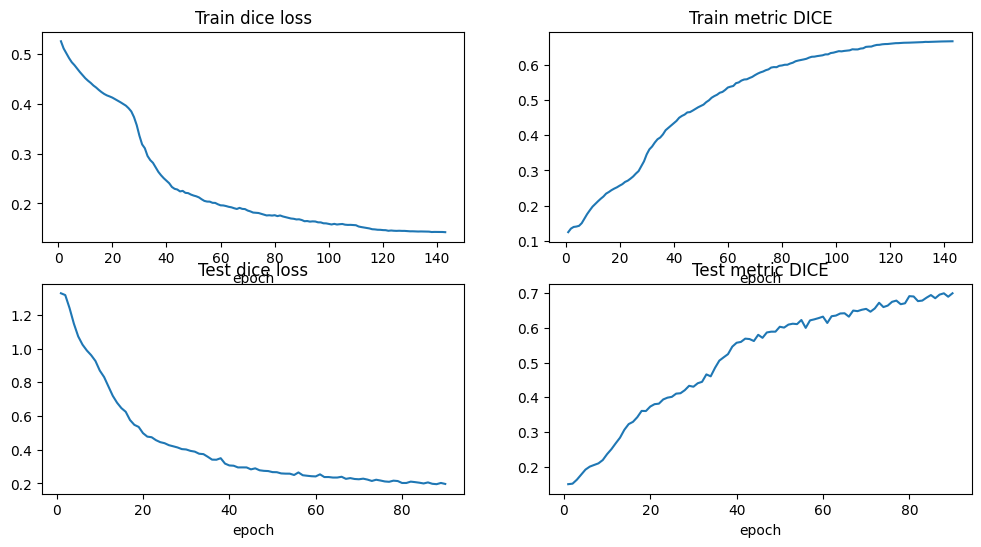

In [ ]:
plt.figure("Results 25 june", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

In [ ]:
data_dir = in_dir
data_dicts = load_data_dicts(data_dir)
# Split dataset into training and validation
# Unlike sklearn's train_test_split, we manually shuffle and split
np.random.shuffle(data_dicts)  # Shuffle the list of patients
split = int(0.8 * len(data_dicts))  # 80-20 split
train_files = data_dicts[:split]
test_files = data_dicts[split:]
#test_files = test_files[5:9]

In [ ]:
test_transforms = Compose(
    [
      LoadImaged(keys=["vol", "seg"], image_only=False, reader="NibabelReader"),
      EnsureChannelFirstD(keys=["vol", "seg"]),
      #transforms.Lambdad(keys=["vol", "seg"], func=lambda x: fix_affine_and_spacing(x, pixdim)),
      Spacingd(keys=["vol", "seg"], pixdim=(1.5, 1.5, 3), mode=("bilinear", "nearest")),
      transforms.NormalizeIntensityd(keys=["vol"], nonzero = True ),
      Orientationd(keys=["vol", "seg"], axcodes="RAS"),
      transforms.ScaleIntensityd(keys = ["vol"], minv = -1.0, maxv = 1.0),
      CropForegroundd(keys=["vol", "seg"], source_key="vol"),
      Resized(keys=["vol", "seg"], spatial_size=(128, 128, 64)),
      # Seg specific transforms
      transforms.CastToTyped(keys=["seg"], dtype=torch.int64),
      #transforms.Lambdad(keys=["seg"], func=lambda x: one_hot(x, num_classes=6)),
      transforms.AsDiscreted(keys=["seg"], to_onehot=6),
      #transforms.EnsureTyped(keys=["seg"], dtype=torch.float32),
      ToTensord(keys=["vol", "seg"])
    ]
)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=4 if torch.cuda.get_device_properties(0).total_memory > 15e9 else 2, num_workers= 4, pin_memory=torch.cuda.is_available())

In [ ]:
test_ds.data

[{'vol': '/content/drive/MyDrive/Colab Notebooks/Lung_cancer_seg/data_nifti_no_groups/patient_3/CT/ct.nii.gz',
  'seg': '/content/drive/MyDrive/Colab Notebooks/Lung_cancer_seg/data_nifti_no_groups/patient_3/masks/combined_masks.nii.gz'},
 {'vol': '/content/drive/MyDrive/Colab Notebooks/Lung_cancer_seg/data_nifti_no_groups/patient_31/CT/ct.nii.gz',
  'seg': '/content/drive/MyDrive/Colab Notebooks/Lung_cancer_seg/data_nifti_no_groups/patient_31/masks/combined_masks.nii.gz'},
 {'vol': '/content/drive/MyDrive/Colab Notebooks/Lung_cancer_seg/data_nifti_no_groups/patient_39/CT/ct.nii.gz',
  'seg': '/content/drive/MyDrive/Colab Notebooks/Lung_cancer_seg/data_nifti_no_groups/patient_39/masks/combined_masks.nii.gz'},
 {'vol': '/content/drive/MyDrive/Colab Notebooks/Lung_cancer_seg/data_nifti_no_groups/patient_18/CT/ct.nii.gz',
  'seg': '/content/drive/MyDrive/Colab Notebooks/Lung_cancer_seg/data_nifti_no_groups/patient_18/masks/combined_masks.nii.gz'},
 {'vol': '/content/drive/MyDrive/Colab Not

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=6,
    #channels=(16, 32, 64, 128, 256),
    channels=(8,16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
      

In [ ]:

def visualize_patient(test_loader, model, patient_idx=0, slice_idx=None, num_classes=6):
    """
    Visualize segmentation results for a specific patient and slice
    Args:
        test_loader: DataLoader containing test dataset
        model: Trained segmentation model
        patient_idx: Index of patient in test_loader to visualize
        slice_idx: Index of slice to display (if None, shows middle slice)
        num_classes: Number of segmentation classes
    """
    # Get the patient data
    model.eval()
    with torch.no_grad():
        batch = next(iter(test_loader))
        vol = batch["vol"][patient_idx].unsqueeze(0).to(device)
        seg = batch["seg"][patient_idx].cpu().numpy()

        # Get prediction
        pred = model(vol)
        pred = torch.softmax(pred, dim=1).cpu().numpy()[0]
        pred_mask = np.argmax(pred, axis=0)

    # Convert to numpy arrays
    ct_slice = vol[0, 0].cpu().numpy()
    gt_mask = np.argmax(seg, axis=0)  # Convert one-hot to class indices

    # Use middle slice if not specified
    if slice_idx is None:
        slice_idx = ct_slice.shape[-1] // 2
    else:
        slice_idx = min(slice_idx, ct_slice.shape[-1]-1)

    # Create figure
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # CT Slice
    ax[0].imshow(ct_slice[..., slice_idx], cmap="gray")
    ax[0].set_title(f"CT Slice {slice_idx}")
    ax[0].axis("off")

    # Ground Truth
    ax[1].imshow(gt_mask[..., slice_idx], cmap="jet", vmin=0, vmax=num_classes-1)
    ax[1].set_title("Ground Truth")
    ax[1].axis("off")

    # Prediction
    ax[2].imshow(pred_mask[..., slice_idx], cmap="jet", vmin=0, vmax=num_classes-1)
    ax[2].set_title("Prediction")
    ax[2].axis("off")

    # Create legend for classes
    class_names = {
        0: "Background",
        1: "Esophagus",
        2: "Heart",
        3: "Lung_L",
        4: "Lung_R",
        5: "SpinalCord"
    }

    # Create legend
    colors = [plt.cm.jet(i/(num_classes-1)) for i in range(num_classes)]
    patches = [plt.plot([],[], marker="s", ms=10, ls="",
                        color=colors[i], label=class_names[i])[0]
              for i in class_names]

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from monai.metrics import DiceMetric
from monai.transforms import (
    Compose,
    AsDiscreted,
    KeepLargestConnectedComponentd,
    EnsureTyped
)

def visualize_patient_with_metrics(test_loader, model, device, patient_idx=0, slice_idx=None):
    """
    Visualize results with Dice metrics and proper postprocessing
    Args:
        test_loader: Test dataset loader
        model: Trained model
        device: CUDA device
        patient_idx: Index of patient in test_loader
        slice_idx: Slice index to visualize (None for middle slice)
    """
    # Define postprocessing transforms (DICTIONARY-based)
    post_transforms = Compose([
        EnsureTyped(keys="pred"),  # Ensure tensor type
        #AsDiscreted(keys="pred", argmax=True),  # Convert logits to class indices
        KeepLargestConnectedComponentd(keys="pred", applied_labels=[1,2,3,4,5], independent=True)
    ])

    # Get data
    model.eval()
    with torch.no_grad():
        batch = next(iter(test_loader))
        volume = batch["vol"][patient_idx].unsqueeze(0).to(device)
        label = batch["seg"][patient_idx].unsqueeze(0).to(device)

        # Get raw prediction (logits)
        raw_pred = model(volume)  # [1, 6, H, W, D]

        # Prepare for postprocessing (keep as logits)
        pred_dict = {"pred": raw_pred.cpu()}  # Maintain logits for proper argmax

        # Apply postprocessing
        # postprocessed_dict = post_transforms(pred_dict)
        # postprocessed = postprocessed_dict["pred"]
        # print('postprocessed shape', postprocessed.shape)

    # Convert to numpy for visualization
    volume_np = volume[0,0].cpu().numpy()  # [H, W, D]
    label_np = torch.argmax(label[0], dim=0).cpu().numpy()  # [H, W, D]
    raw_pred_np = torch.argmax(raw_pred[0], dim=0).cpu().numpy()  # [H, W, D]

    # Get slice index
    if slice_idx is None:
        slice_idx = volume_np.shape[-1] // 2

    # Calculate Dice
    dice_score = dice_metric(torch.argmax(raw_pred[0], dim=0).cpu(), torch.argmax(label[0], dim=0).cpu())
    class_dice = class_wise_dice(raw_pred_np, label_np, slice_idx=slice_idx)
    calculated_dice = calculate_dice(raw_pred_np, label_np, slice_idx=slice_idx)

    #postprocessed_np = torch.argmax(postprocessed[0], dim=0).cpu().numpy()  # [H, W, D]

    # Verify class labels during visualization
    #print("Ground truth class indices:", np.unique(label_np))

    # Create plot
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # CT Image
    axes[0].imshow(volume_np[..., slice_idx+1], cmap='gray')
    axes[0].set_title(f'CT Slice {slice_idx+1}')

    # Ground Truth
    axes[1].imshow(label_np[..., slice_idx+1], cmap='jet', vmin=0, vmax=5)
    axes[1].set_title('Ground Truth')

    # Raw Prediction
    axes[2].imshow(raw_pred_np[..., slice_idx+1], cmap='jet', vmin=0, vmax=5)
    axes[2].set_title(f'Raw Prediction\n Dice Metric: {dice_score:.4f} and Manual Dice: {calculated_dice:.4f}\n'
                      f'Esophagus: {class_dice[0]:.2f} Heart: {class_dice[1]:.2f}\n'
                      f'Lungs: {np.mean(class_dice[2:4]):.2f} Spinal: {class_dice[4]:.2f}\n')

    # Postprocessed Prediction
    #axes[3].imshow(postprocessed_np[..., slice_idx], cmap='jet', vmin=0, vmax=5)
    #axes[3].set_title('Postprocessed')

    # Add legend
    class_names = {
        0: 'Background',
        1: 'Esophagus',
        2: 'Heart',
        3: 'Lung_L',
        4: 'Lung_R',
        5: 'SpinalCord'
    }

    from matplotlib.patches import Patch
    colors = [plt.cm.jet(i/5) for i in range(6)]
    patches = [Patch(color=colors[i], label=class_names[i]) for i in class_names]

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def class_wise_dice(pred, target, slice_idx):
    dices = []
    for i in range(1, 6):  # Skip background
        pred_mask = (pred[..., slice_idx] == i)
        target_mask = (target[..., slice_idx] == i)
        intersection = np.sum(pred_mask & target_mask)
        dice = 2*intersection / (np.sum(pred_mask) + np.sum(target_mask) + 1e-8)
        dices.append(dice.item())

    #print(dices)
    return dices

def calculate_dice(pred, target, slice_idx):

    intersection = np.sum(pred & target)
    dice = 2*intersection / (np.sum(pred) + np.sum(target) + 1e-8)
    #print(f'calculated_dice: {dice}')

    return dice

def dice_metric(predicted, target):

    # Apply softmax
    pred_activated = torch.softmax(predicted.float(), dim=1)

    # Calculate class-weighted Dice
    dice_metric = DiceMetric(
        include_background=False,
        reduction="mean",
        get_not_nans=False
    )

    dice_metric(y_pred=pred_activated, y=target)
    #print('dice_score',dice_metric.aggregate().item())
    return dice_metric.aggregate().item()

    return dice


Ground truth class indices: [0 1 2 3 4 5]


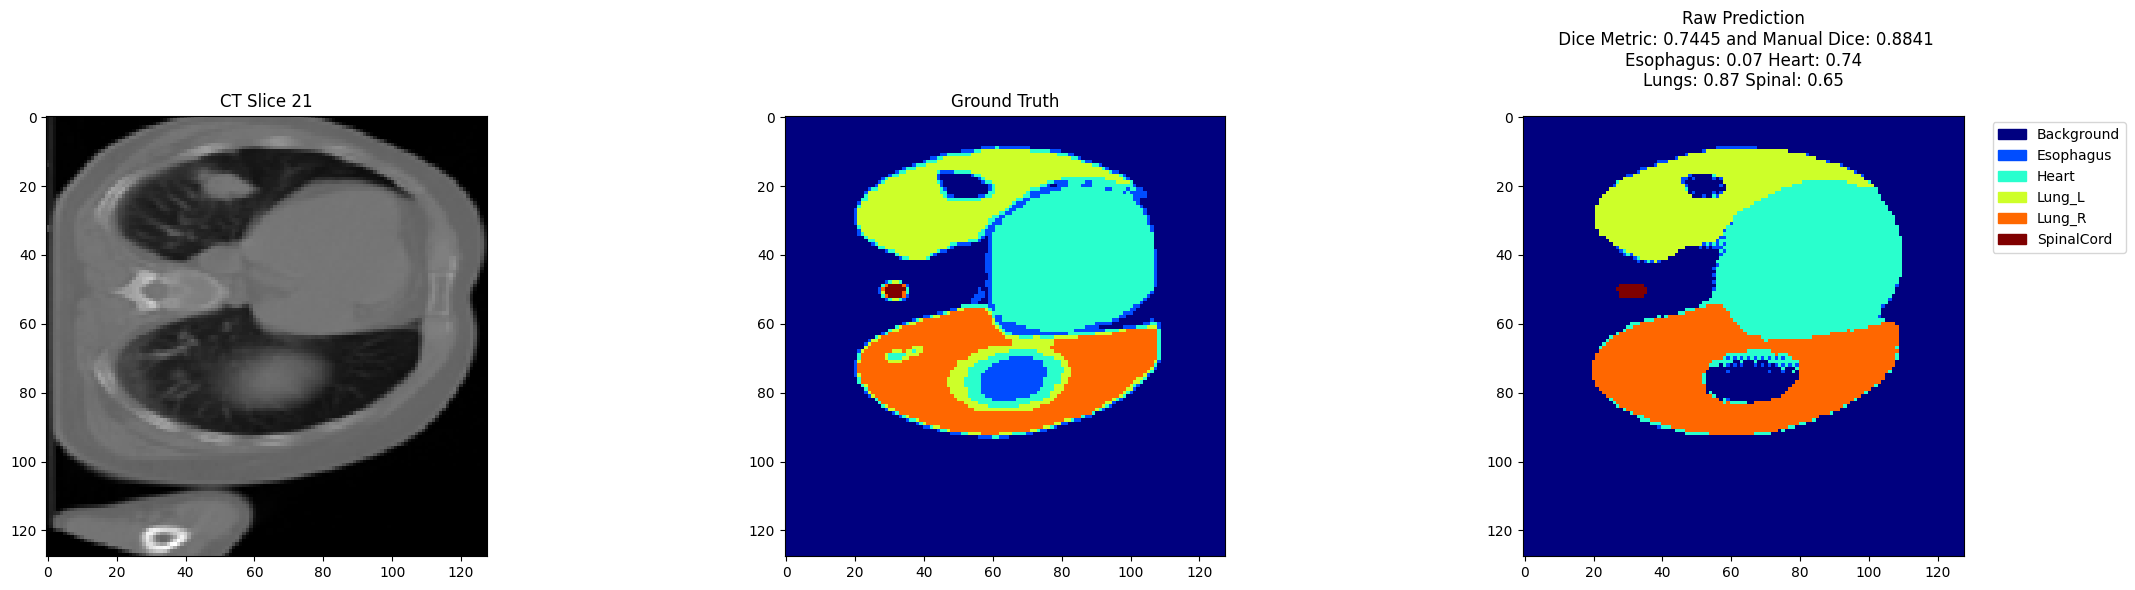

Ground truth class indices: [0 1 2 3 4 5]


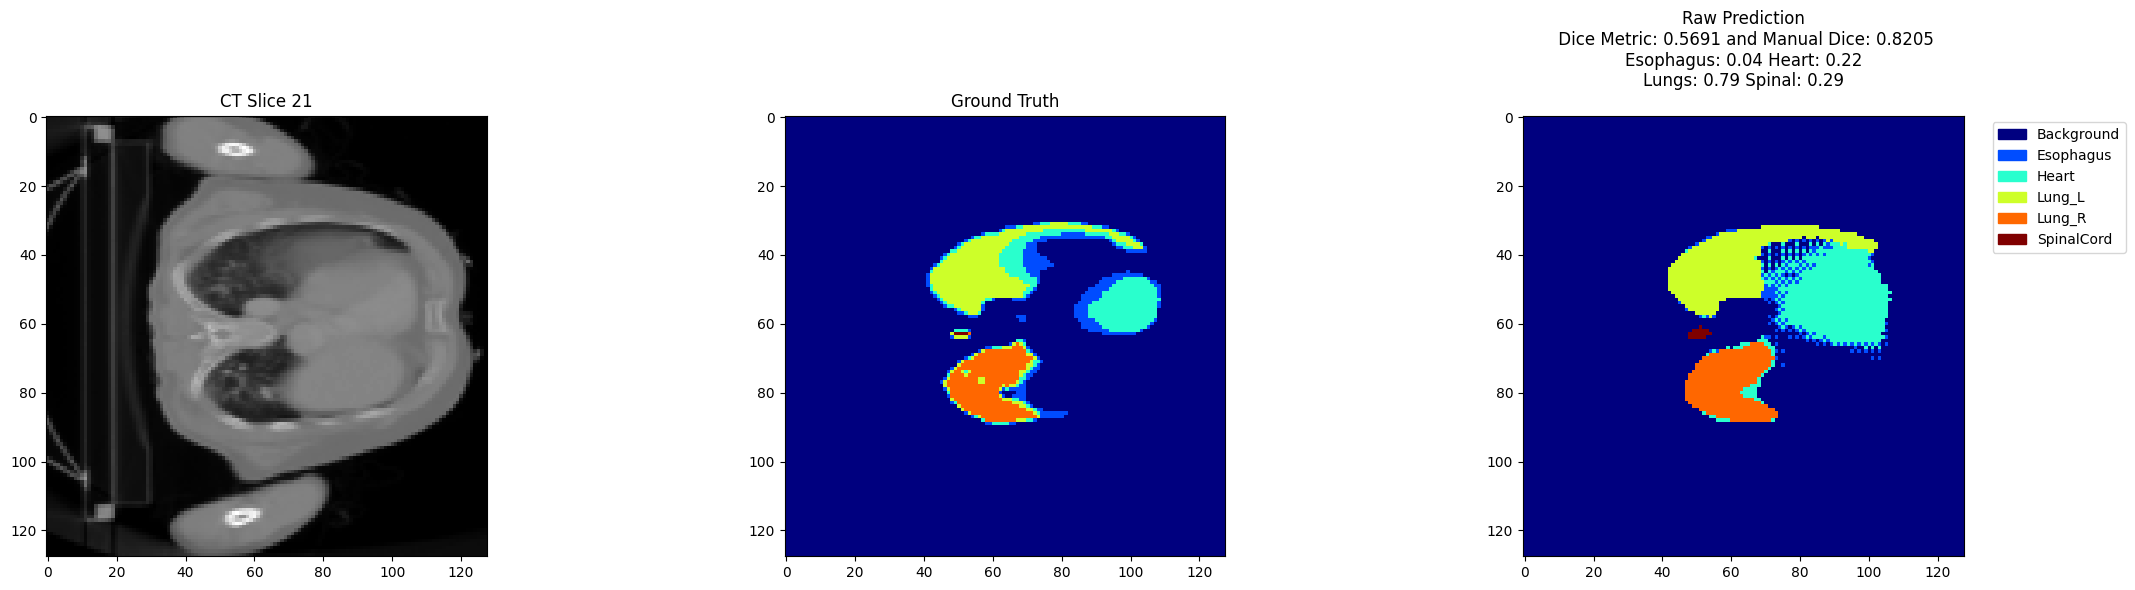

In [ ]:

# Visualize multiple patients
for i in range(2):
    visualize_patient_with_metrics(
        test_loader=test_loader,
        model=model,
        device=device,
        patient_idx=i,
        slice_idx=1
    )

# COMPUTING EVALUATION METRICS

In this part we can to calculate dice metric, HD95 and MSD at patient-organ level, for all validation patients. Lets start with functions to compute dice and prepare necessary libraries, data and model.

In [ ]:
!pip install monai nibabel SimpleITK scikit-image scipy

In [ ]:
import os
from glob import glob
import shutil
import nibabel as nib
import SimpleITK as sitk
from monai import transforms
from monai.transforms import (
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from monai.networks.layers import Dropout, Act
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss
from monai.networks import one_hot
import matplotlib.pyplot as plt
from monai.inferers import sliding_window_inference
from google.colab import drive
# Add mixed precision training imports
from torch.cuda.amp import autocast, GradScaler  # ⬅◀ For faster training
from scipy.ndimage import distance_transform_edt

set_determinism(seed=0)

In [ ]:
drive.mount('/content/drive')         # ⬅◀ Mount your Drive

Mounted at /content/drive


In [ ]:
def load_data_dicts(data_dir):
   """
   Creates a list of dictionaries pointing to our data files
   Why needed? MONAI expects data in this format for its Dataset class
   Similar to creating a pandas DataFrame with file paths
   """
   data_dicts = []
   patient_dirs = glob(os.path.join(data_dir, "patient_*"))  # Get all patient directories
   for patient_dir in patient_dirs:
       ct_path = os.path.join(patient_dir, "CT", "ct.nii.gz")
       mask_path = os.path.join(patient_dir, "masks", "combined_masks.nii.gz")
       # Only include patients with both CT and mask files
       if os.path.exists(ct_path) and os.path.exists(mask_path):
           data_dicts.append({"vol": ct_path, "seg": mask_path})
   return data_dicts

in_dir = "/content/drive/MyDrive/Colab Notebooks/Lung_cancer_seg/data_nifti_no_groups"
model_dir = '/content/drive/MyDrive/Colab Notebooks/Lung_cancer_seg/results_lung_seg_yt'

data_dir = in_dir
data_dicts = load_data_dicts(data_dir)
# Split dataset into training and validation
# Unlike sklearn's train_test_split, we manually shuffle and split
np.random.shuffle(data_dicts)  # Shuffle the list of patients
split = int(0.8 * len(data_dicts))  # 80-20 split
train_files = data_dicts[:split]
test_files = data_dicts[split:]
#test_files = test_files[5:9]

test_transforms = Compose(
    [
      LoadImaged(keys=["vol", "seg"], image_only=False, reader="NibabelReader"),
      EnsureChannelFirstD(keys=["vol", "seg"]),
      #transforms.Lambdad(keys=["vol", "seg"], func=lambda x: fix_affine_and_spacing(x, pixdim)),
      Spacingd(keys=["vol", "seg"], pixdim=(1.5, 1.5, 3), mode=("bilinear", "nearest")),
      transforms.NormalizeIntensityd(keys=["vol"], nonzero = True ),
      Orientationd(keys=["vol", "seg"], axcodes="RAS"),
      transforms.ScaleIntensityd(keys = ["vol"], minv = -1.0, maxv = 1.0),
      CropForegroundd(keys=["vol", "seg"], source_key="vol"),
      Resized(keys=["vol", "seg"], spatial_size=(128, 128, 64)),
      # Seg specific transforms
      transforms.CastToTyped(keys=["seg"], dtype=torch.int64),
      #transforms.Lambdad(keys=["seg"], func=lambda x: one_hot(x, num_classes=6)),
      transforms.AsDiscreted(keys=["seg"], to_onehot=6),
      #transforms.EnsureTyped(keys=["seg"], dtype=torch.float32),
      ToTensord(keys=["vol", "seg"])
    ]
)

test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=4 if torch.cuda.get_device_properties(0).total_memory > 15e9 else 2, num_workers= 4, pin_memory=torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=6,
    #channels=(16, 32, 64, 128, 256),
    channels=(8,16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
      

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from monai.metrics import DiceMetric
from monai.transforms import (
    Compose,
    AsDiscreted,
    KeepLargestConnectedComponentd,
    EnsureTyped
)

def class_wise_dice(pred, target):
    dices = []
    for i in range(1, 6):  # Skip background
        pred_mask = (pred == i)
        target_mask = (target == i)
        intersection = np.sum(pred_mask & target_mask)
        dice = 2*intersection / (np.sum(pred_mask) + np.sum(target_mask) + 1e-8)
        dice = round(dice, 3)
        dices.append(dice.item())

    #print(dices)
    return dices

def calculate_dice(pred, target):

    intersection = np.sum(pred & target)
    dice = 2*intersection / (np.sum(pred) + np.sum(target) + 1e-8)
    dice = round(dice, 3)
    #print(f'calculated_dice: {dice}')

    return dice

def dice_metric(predicted, target):

    # Apply softmax
    pred_activated = torch.softmax(predicted.float(), dim=1)

    # Calculate class-weighted Dice
    dice_metric = DiceMetric(
        include_background=False,
        reduction="mean",
        get_not_nans=False
    )

    dice_metric(y_pred=pred_activated, y=target)
    #print('dice_score',dice_metric.aggregate().item())
    return dice_metric.aggregate().item()

    return dice

Now lets compute HD95

In [ ]:
from scipy.ndimage import binary_dilation

def calculate_hd95(pred_mask, target_mask):
    """
    Compute HD95 for a specific class and slice.

    Args:
        pred_mask (np.array): Raw prediction mask [H, W, D]
        target_mask (np.array): Ground truth mask [H, W, D]

    Returns:
        hd95 (float): HD95 score for the specified class/slice
    """

    # Case 1: True Negative (both empty)
    if np.sum(target_mask) == 0 and np.sum(pred_mask) == 0:
        #print(slice_idx)
        return 0  # Exclude from avg

    # Case 2: False Negative (target exists, prediction missing)
    if np.sum(target_mask) > 0 and np.sum(pred_mask) == 0:
        return 70  # Arbitrary large value (adjust based on your data)

    # Case 3: False Positive (prediction exists, target missing)
    if np.sum(pred_mask) > 0 and np.sum(target_mask) == 0:
        return 70

    # Case 4: Valid comparison (both have the class)
    # Proceed with actual HD95 calculation
    # Compute surface boundaries using edge detection
    # (1 pixel dilation to capture boundaries)
    pred_edges = np.logical_xor(pred_mask, binary_dilation(pred_mask))  # Prediction surface
    target_edges = np.logical_xor(target_mask, binary_dilation(target_mask))  # Target surface

    # Calculate distance transform from target surface to all other points
    # (How far each point is from the nearest target surface)
    target_dist = distance_transform_edt(np.logical_not(target_edges))  # [H, W]

    # Get distances for all predicted edge points to nearest target edge
    pred_to_target_dists = target_dist[pred_edges]  # Distances from pred edges to target edges

    # Compute 95th percentile of distances (ignore NaN)
    #if pred_to_target_dists.size == 0:
    #    return np.nan
    try:
      hd95_forward = np.percentile(pred_to_target_dists, 95)  # 95th percentile
    except:
      hd95_forward = 0

    # Repeat in reverse direction (target edges to predicted edges)
    pred_dist = distance_transform_edt(np.logical_not(pred_edges))
    target_to_pred_dists = pred_dist[target_edges]

    try:
      hd95_backward = np.percentile(target_to_pred_dists, 95) if target_to_pred_dists.size > 0 else 0
    except:
      hd95_backward = 0

    # HD95 is the maximum of forward and backward directions
    hd95 = max(hd95_forward, hd95_backward)

    return hd95

# HD95 for each class and slice:

def hd95_per_organ(raw_pred_np, label_np):
    hd95_per_organ = []
    for i in range(1,6):  # Skip background (0)
        hd95 = calculate_hd95(
            pred_mask=(raw_pred_np==i).astype(np.uint8),
            target_mask=(label_np==i).astype(np.uint8)
        )
        hd95 = round(hd95, 3)
        hd95_per_organ.append(hd95)

    return hd95_per_organ


Now lets compute MSD (Mean Surface Distance).

In [ ]:
from scipy.ndimage import binary_dilation

def calculate_msd(pred_mask, target_mask, voxel_spacing):
    """
    Compute Mean Surface Distance (MSD) for a specific class and slice.

    Args:
        pred_mask (np.array): Raw prediction mask [H, W, D] (class indices)
        target_mask (np.array): Ground truth mask [H, W, D] (class indices)
        voxel_spacing (tuple): Physical spacing (x, y, z) in mm

    Returns:
        msd (float): Mean Surface Distance in mm (NaN if invalid)
    """

    # Case 1: True Negative (both empty)
    if np.sum(target_mask) == 0 and np.sum(pred_mask) == 0:
        #print(slice_idx)
        return np.nan  # Exclude from avg

    # Case 2: False Negative (target exists, prediction missing)
    if np.sum(target_mask) > 0 and np.sum(pred_mask) == 0:
        return 70  # Arbitrary large value (adjust based on your data)

    # Case 3: False Positive (prediction exists, target missing)
    if np.sum(pred_mask) > 0 and np.sum(target_mask) == 0:
        return 70

    # Case 4: Valid comparison (both have the class)
    # Proceed with actual MSD calculation
    # Compute surface boundaries using edge detection
    # (1 pixel dilation to capture boundaries)
    pred_edges = np.logical_xor(pred_mask, binary_dilation(pred_mask))  # Prediction surface
    target_edges = np.logical_xor(target_mask, binary_dilation(target_mask))  # Target surface

    # Calculate distance transform from target surface to all other points
    # (How far each point is from the nearest target surface)
    target_dist = distance_transform_edt(np.logical_not(target_edges), sampling=voxel_spacing[:2])  # [H, W]

    pred_dist = distance_transform_edt(np.logical_not(pred_edges), sampling=voxel_spacing[:2])

    # Directed MSD: Prediction → Target
    if np.sum(pred_edges) > 0:
        pred_to_target = np.mean(target_dist[pred_edges])
    else:
        pred_to_target = 0.0

    # Directed MSD: Target → Prediction
    if np.sum(target_edges) > 0:
        target_to_pred = np.mean(pred_dist[target_edges])
    else:
        target_to_pred = 0.0

    # Symmetric MSD
    msd = (pred_to_target + target_to_pred) / 2

    return msd

# MSD for each class and slice:

def msd_per_organ(raw_pred_np, label_np, voxel_spacing):
    msd_per_organ = []
    for i in range(1,6):  # Skip background (0)
        msd = calculate_msd(
            pred_mask=(raw_pred_np==i).astype(np.uint8),
            target_mask=(label_np==i).astype(np.uint8),
            voxel_spacing=voxel_spacing # your CT spacing
        )
        #if not np.isnan(msd):
        msd = round(msd, 3)
        msd_per_organ.append(msd)

    return msd_per_organ

In [ ]:
def visualize_patient_slices_with_metrics(test_loader, model, device, patient_idx=0):
    """
    Visualize results with Dice metrics and proper postprocessing
    Args:
        test_loader: Test dataset loader
        model: Trained model
        device: CUDA device
        patient_idx: Index of patient in test_loader
    """
    # Define postprocessing transforms (DICTIONARY-based)
    post_transforms = Compose([
        EnsureTyped(keys="pred"),  # Ensure tensor type
        #AsDiscreted(keys="pred", argmax=True),  # Convert logits to class indices
        KeepLargestConnectedComponentd(keys="pred", applied_labels=[1,2,3,4,5], independent=True)
    ])

    # Get data
    model.eval()
    with torch.no_grad():
        batch = next(iter(test_loader))
        volume = batch["vol"][patient_idx].unsqueeze(0).to(device)
        label = batch["seg"][patient_idx].unsqueeze(0).to(device)

        # Get raw prediction (logits)
        raw_pred = model(volume)  # [1, 6, H, W, D]

        # Prepare for postprocessing (keep as logits)
        pred_dict = {"pred": raw_pred.cpu()}  # Maintain logits for proper argmax

        # Apply postprocessing
        # postprocessed_dict = post_transforms(pred_dict)
        # postprocessed = postprocessed_dict["pred"]
        # print('postprocessed shape', postprocessed.shape)

    # Convert to numpy for visualization
    volume_np = volume[0,0].cpu().numpy()  # [H, W, D]
    label_np = torch.argmax(label[0], dim=0).cpu().numpy()  # [H, W, D]
    raw_pred_np = torch.argmax(raw_pred[0], dim=0).cpu().numpy()  # [H, W, D]

    for slice_idx in range(raw_pred_np.shape[-1]):

      # Get slice information
      raw_pred_slice = raw_pred_np[..., slice_idx]
      label_slice = label_np[..., slice_idx]

      # Calculate Dice
      dice_score = dice_metric(torch.argmax(raw_pred[0], dim=0).cpu(), torch.argmax(label[0], dim=0).cpu())
      class_dice = class_wise_dice(raw_pred_slice, label_slice)
      calculated_dice = calculate_dice(raw_pred_slice, label_slice)

      #postprocessed_np = torch.argmax(postprocessed[0], dim=0).cpu().numpy()  # [H, W, D]

      # Create plot
      fig, axes = plt.subplots(1, 3, figsize=(24, 6))

      # CT Image
      axes[0].imshow(volume_np[..., slice_idx+1], cmap='gray')
      axes[0].set_title(f'CT Slice {slice_idx+1}')

      # Ground Truth
      axes[1].imshow(label_np[..., slice_idx+1], cmap='jet', vmin=0, vmax=5)
      axes[1].set_title('Ground Truth')

      # Raw Prediction
      axes[2].imshow(raw_pred_np[..., slice_idx+1], cmap='jet', vmin=0, vmax=5)
      axes[2].set_title(f'Raw Prediction\n Dice Metric: {dice_score:.4f} and Manual Dice: {calculated_dice:.4f}\n'
                        f'Esophagus: {class_dice[0]:.2f} Heart: {class_dice[1]:.2f}\n'
                        f'Lungs: {np.mean(class_dice[2:4]):.2f} Spinal: {class_dice[4]:.2f}\n')

      # Postprocessed Prediction
      #axes[3].imshow(postprocessed_np[..., slice_idx], cmap='jet', vmin=0, vmax=5)
      #axes[3].set_title('Postprocessed')

      # Add legend
      class_names = {
          0: 'Background',
          1: 'Esophagus',
          2: 'Heart',
          3: 'Lung_L',
          4: 'Lung_R',
          5: 'SpinalCord'
      }

      from matplotlib.patches import Patch
      colors = [plt.cm.jet(i/5) for i in range(6)]
      patches = [Patch(color=colors[i], label=class_names[i]) for i in class_names]

      plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
      plt.tight_layout()
      plt.show()

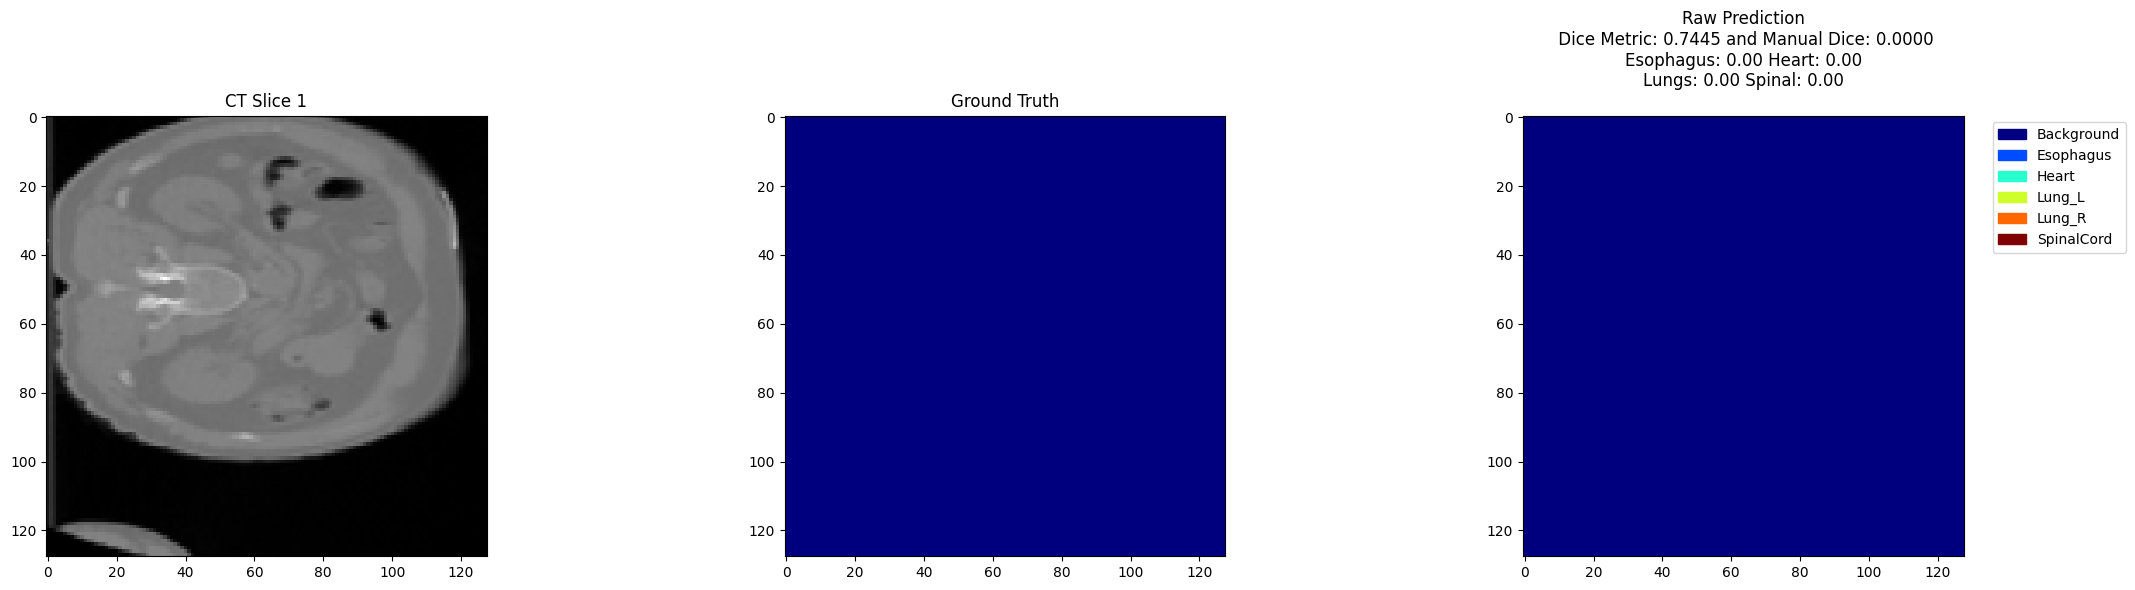

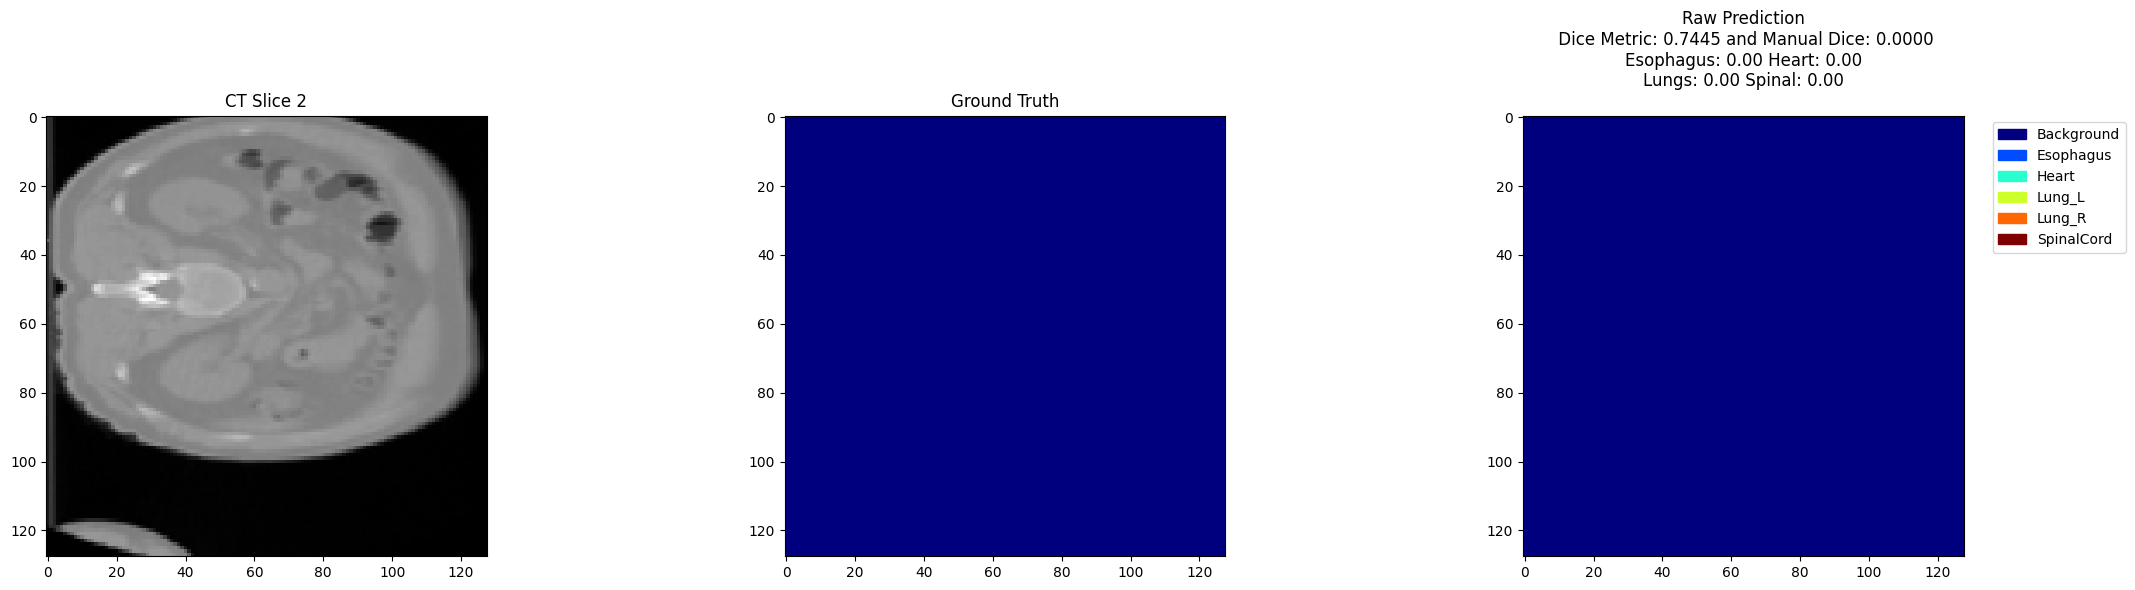

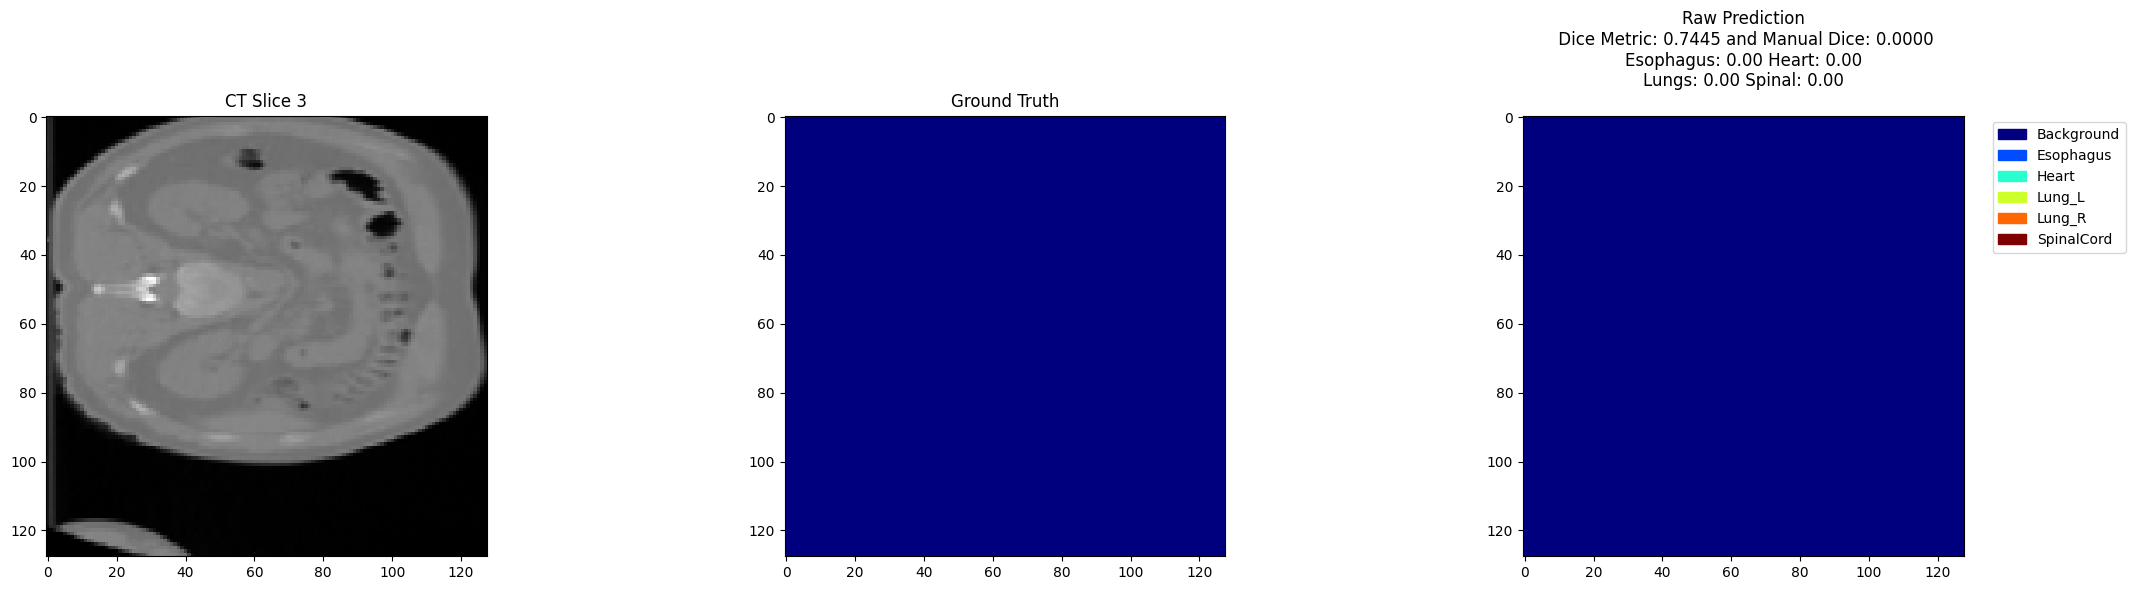

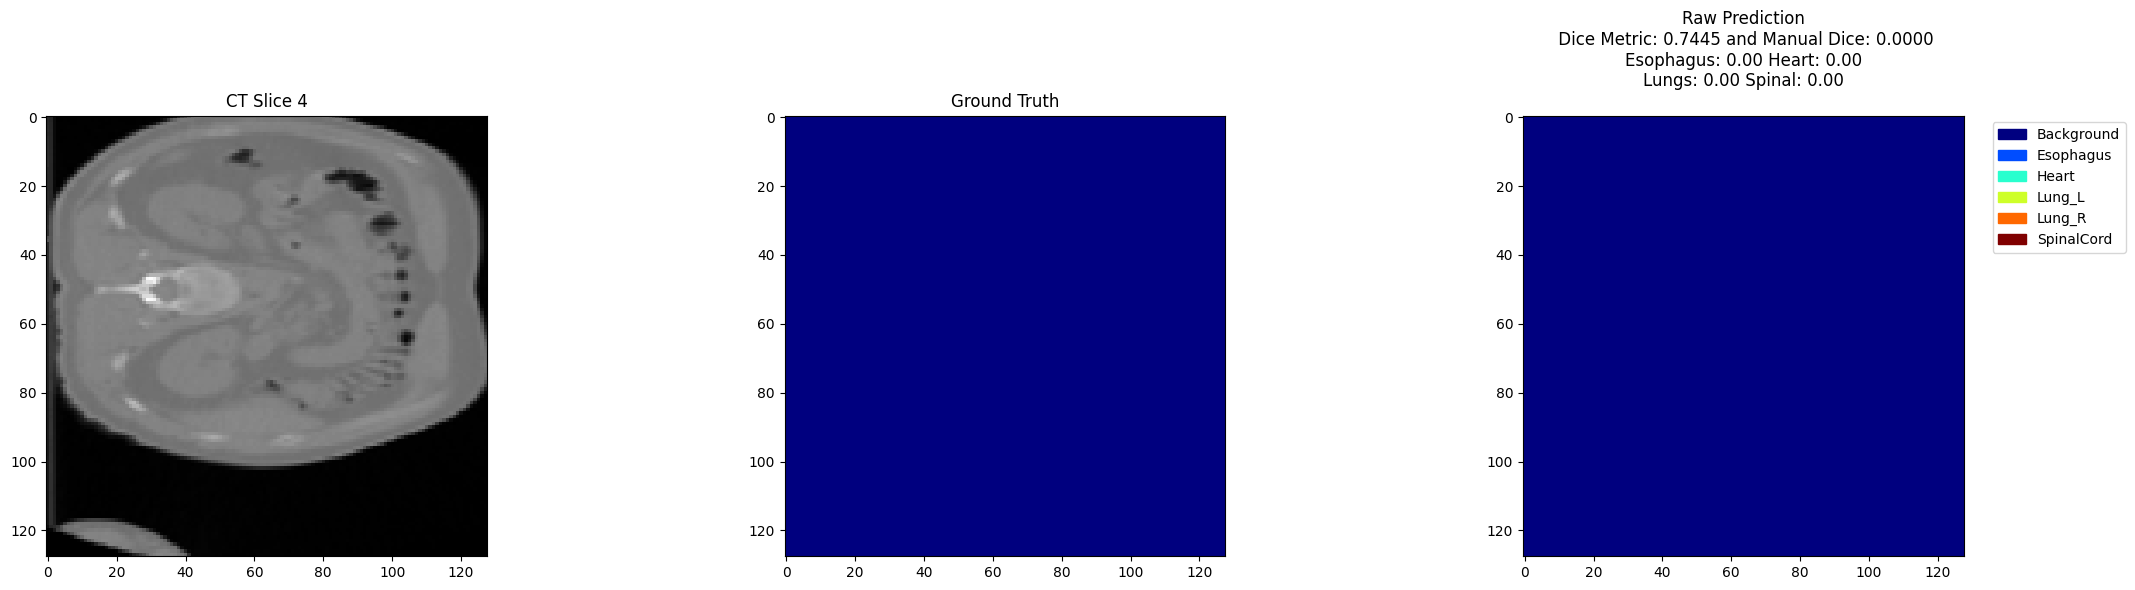

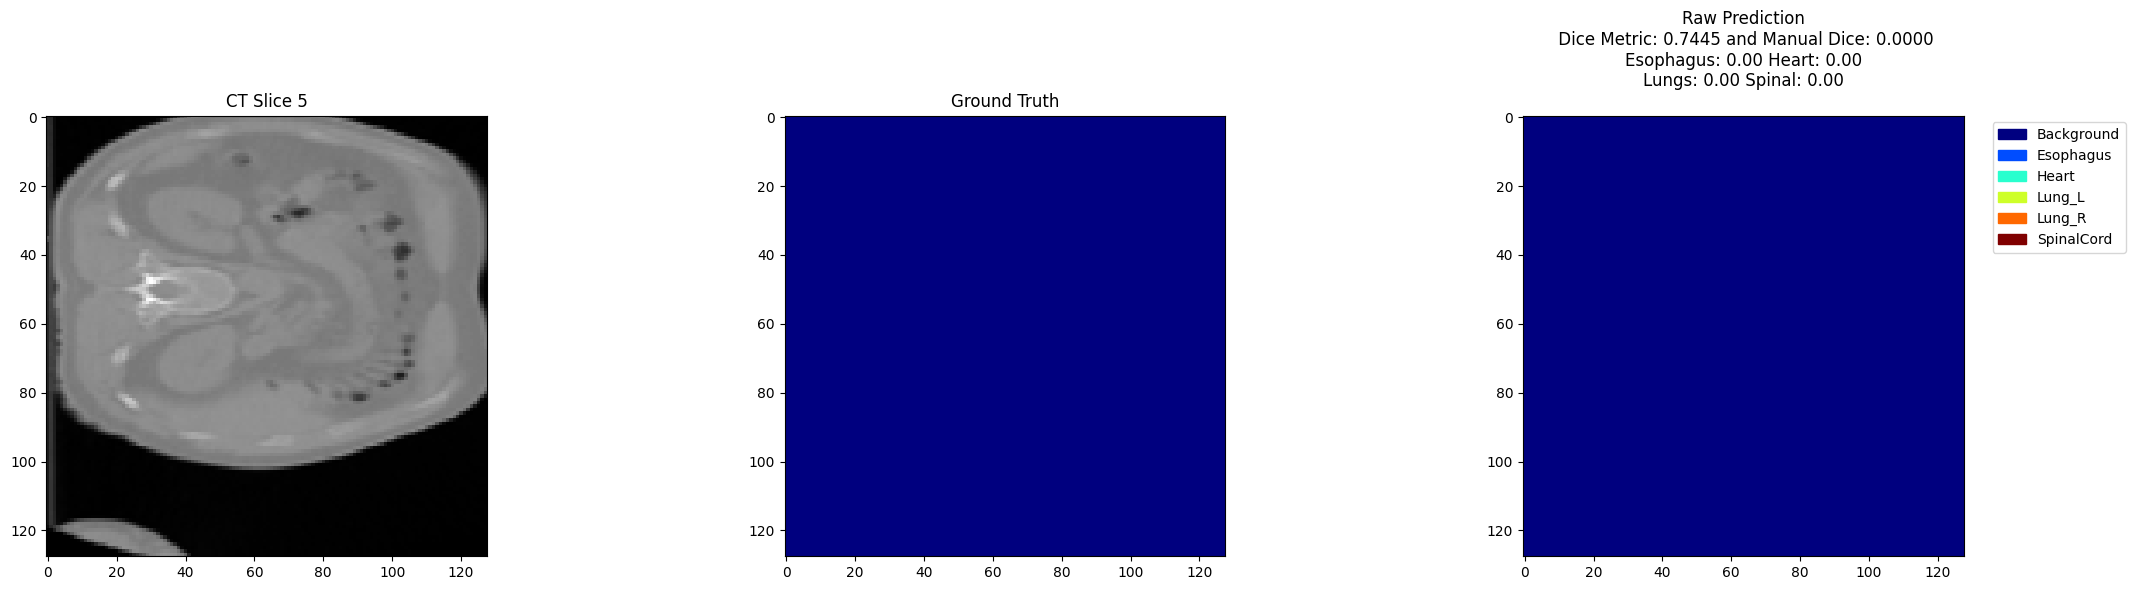

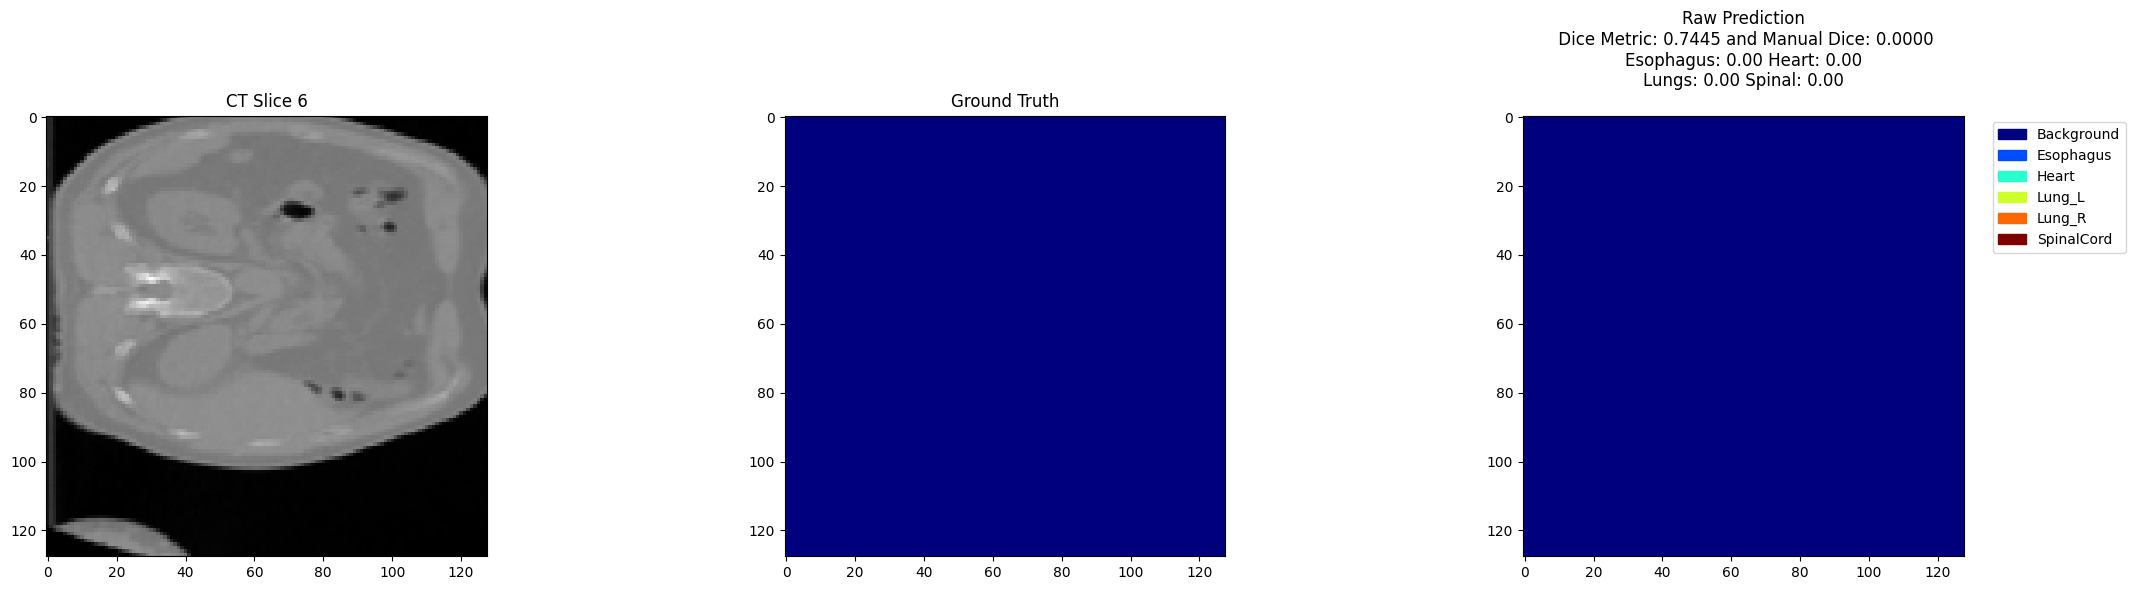

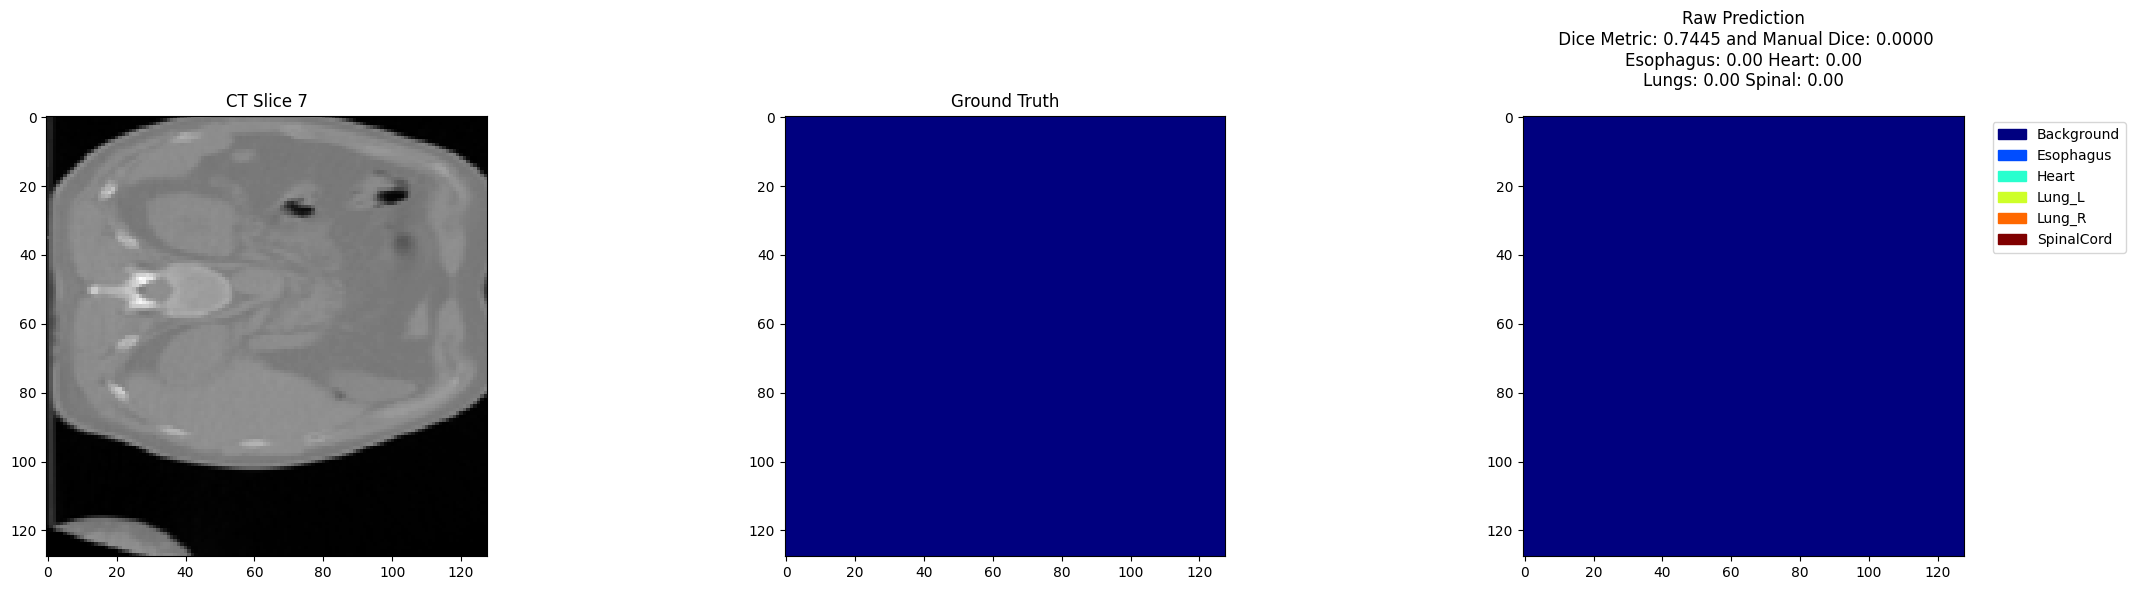

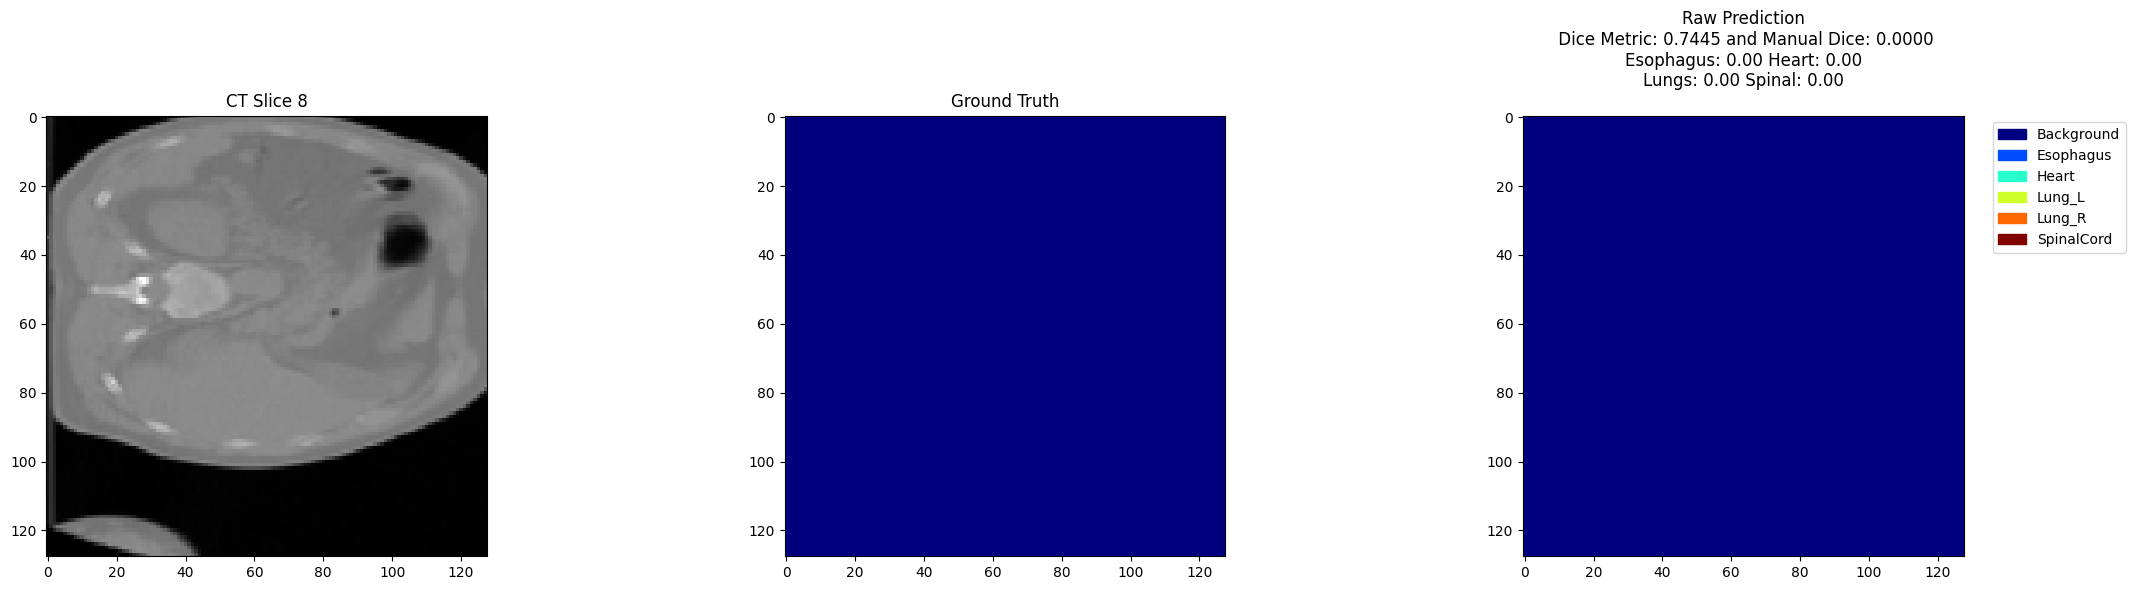

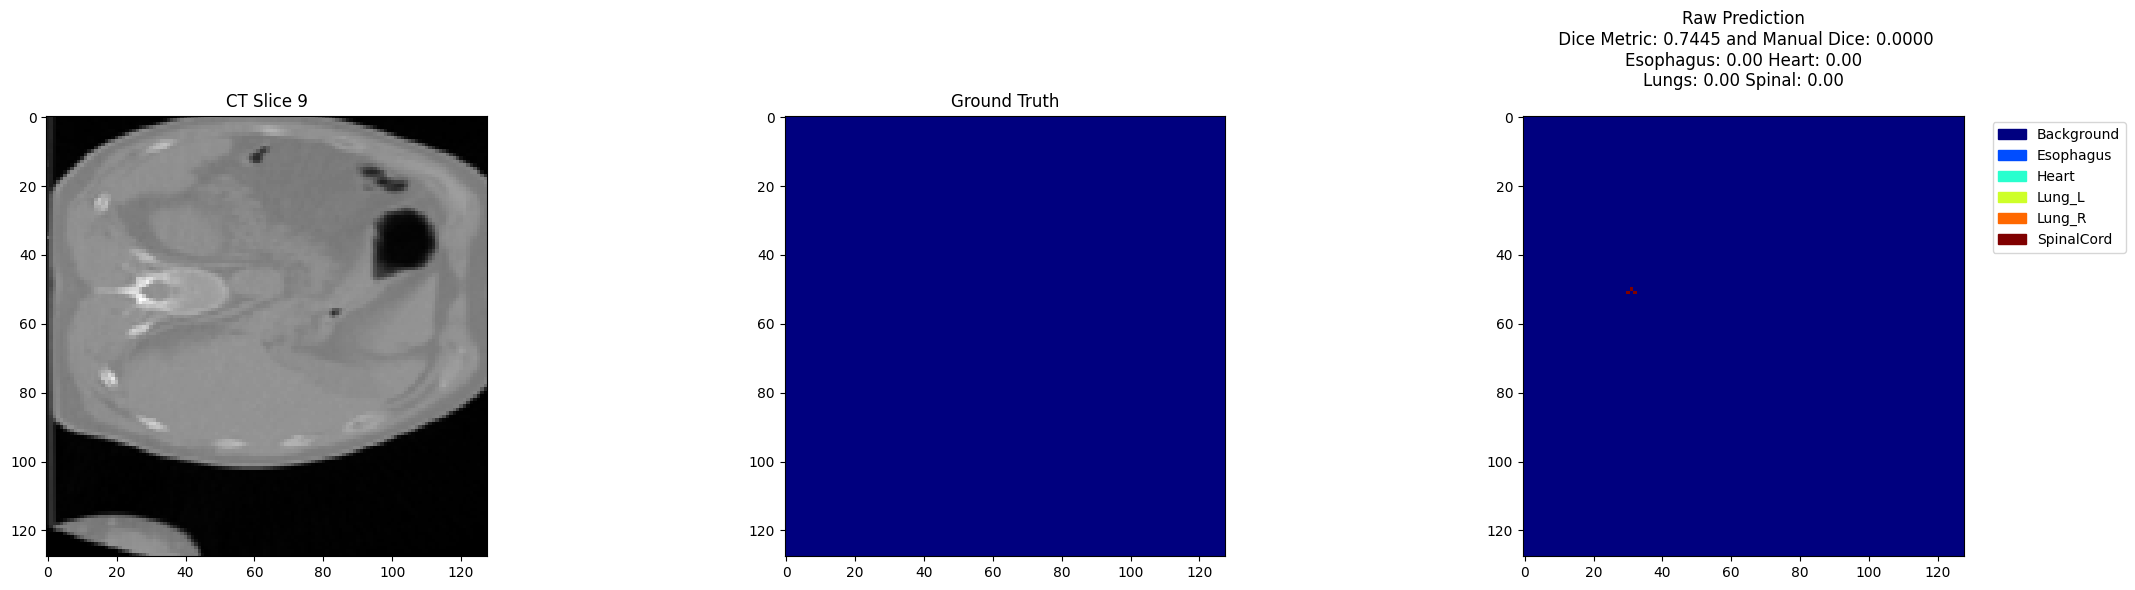

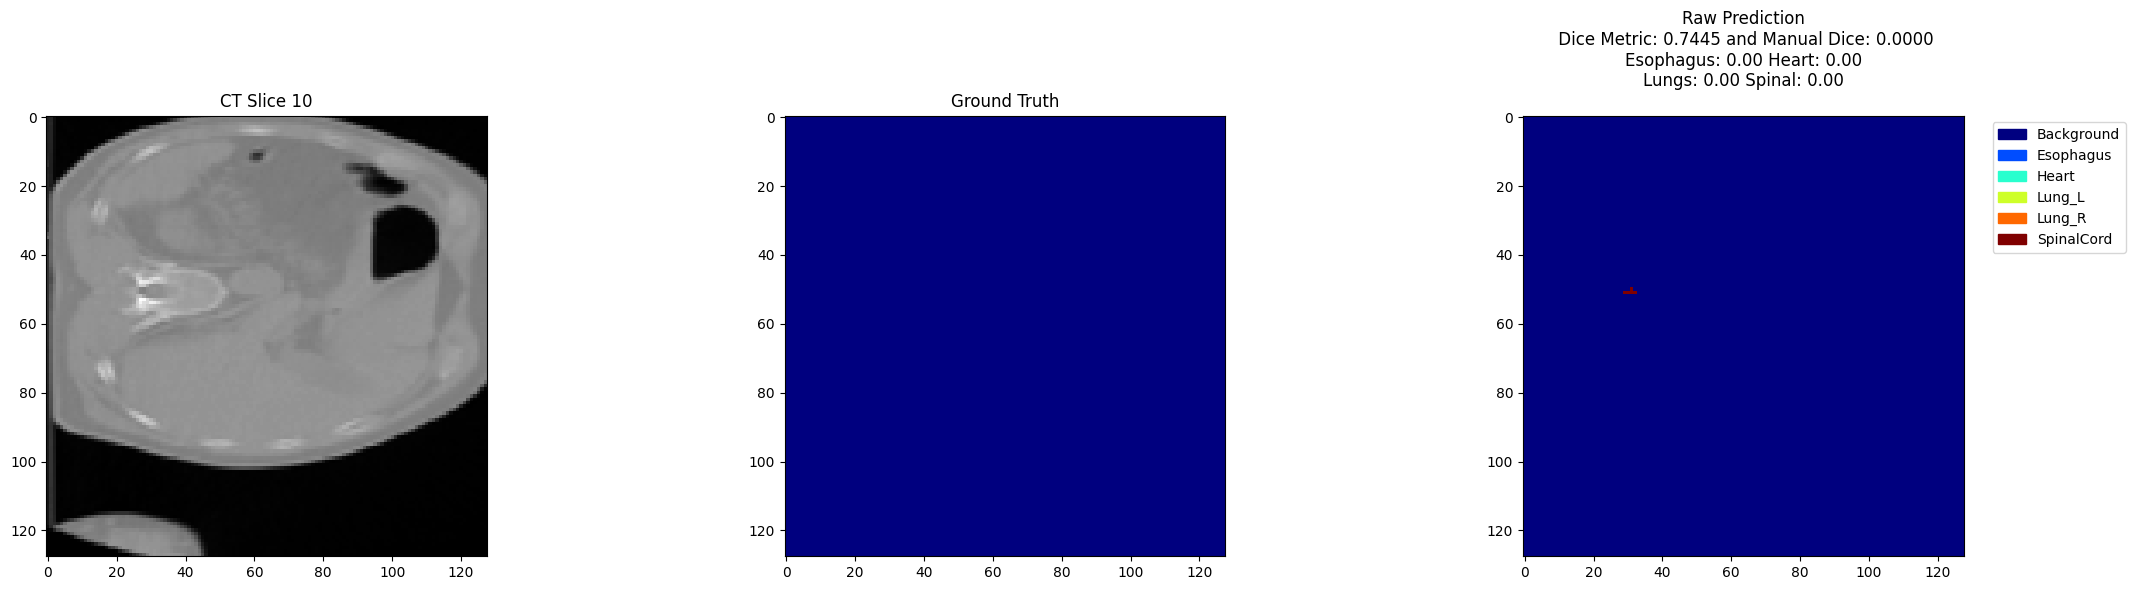

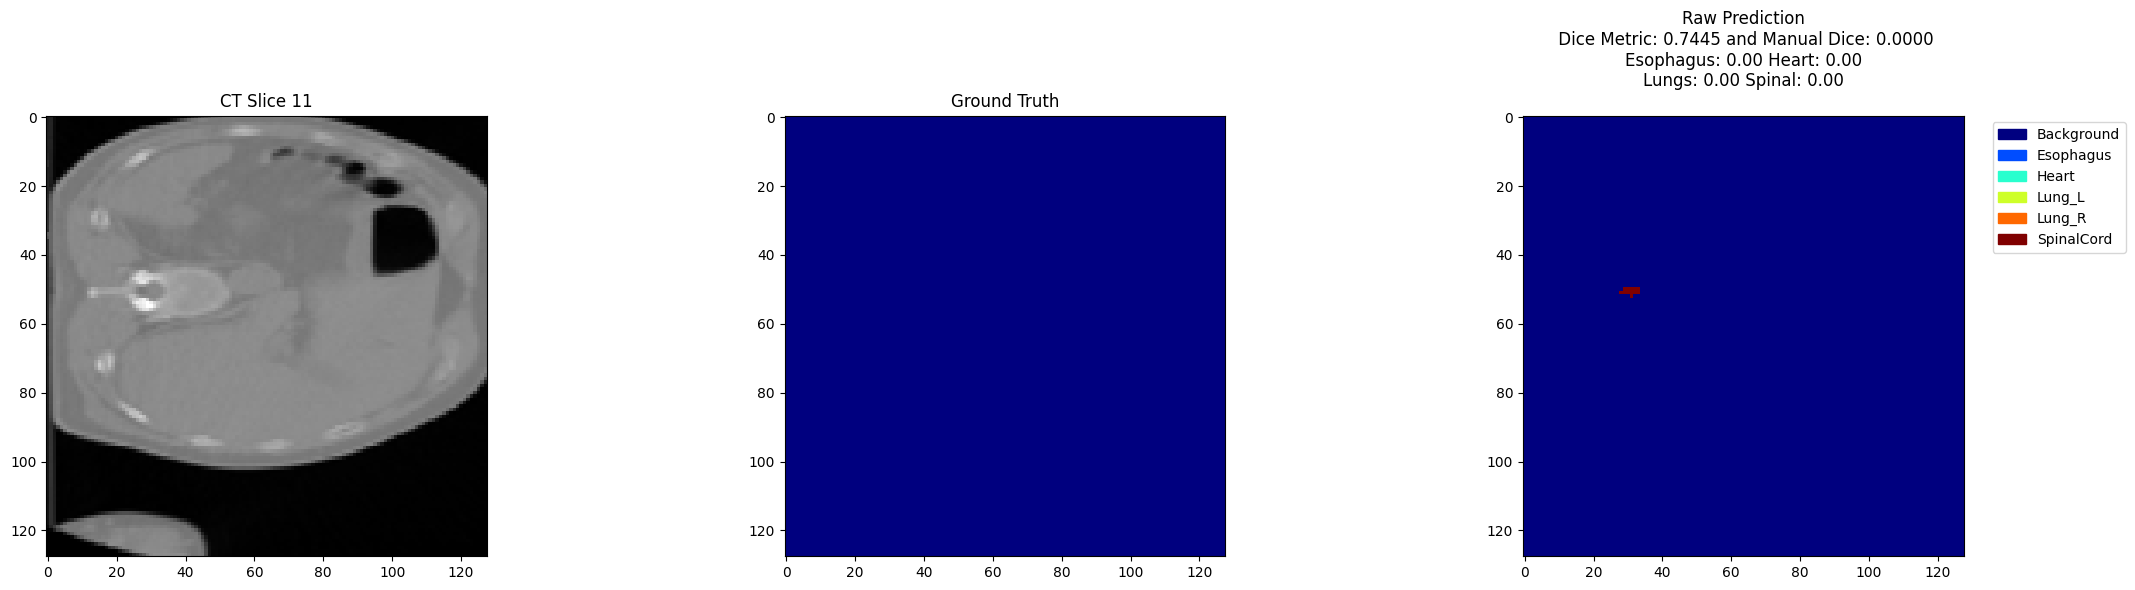

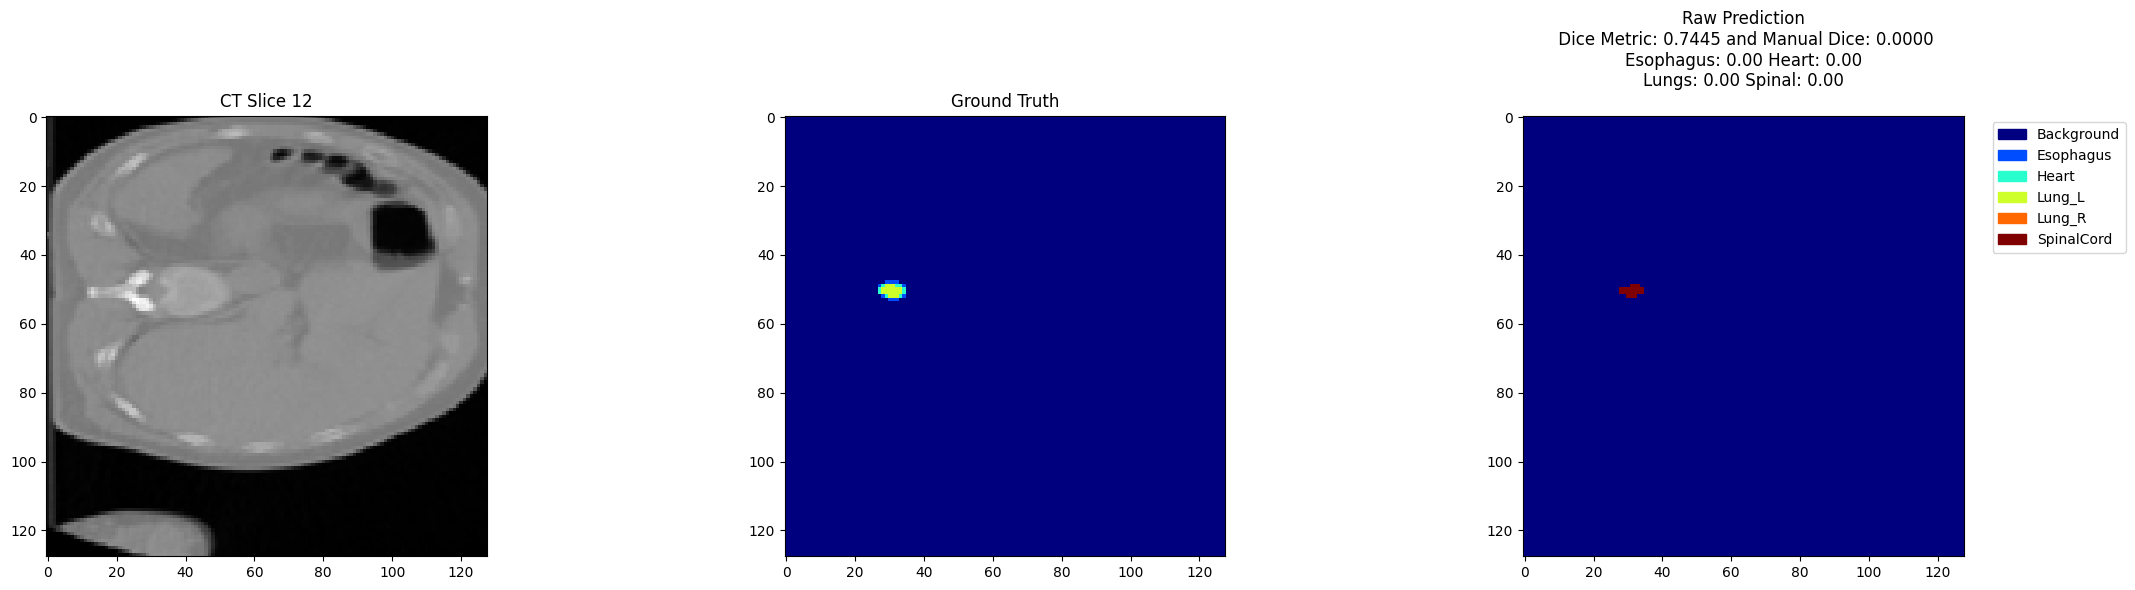

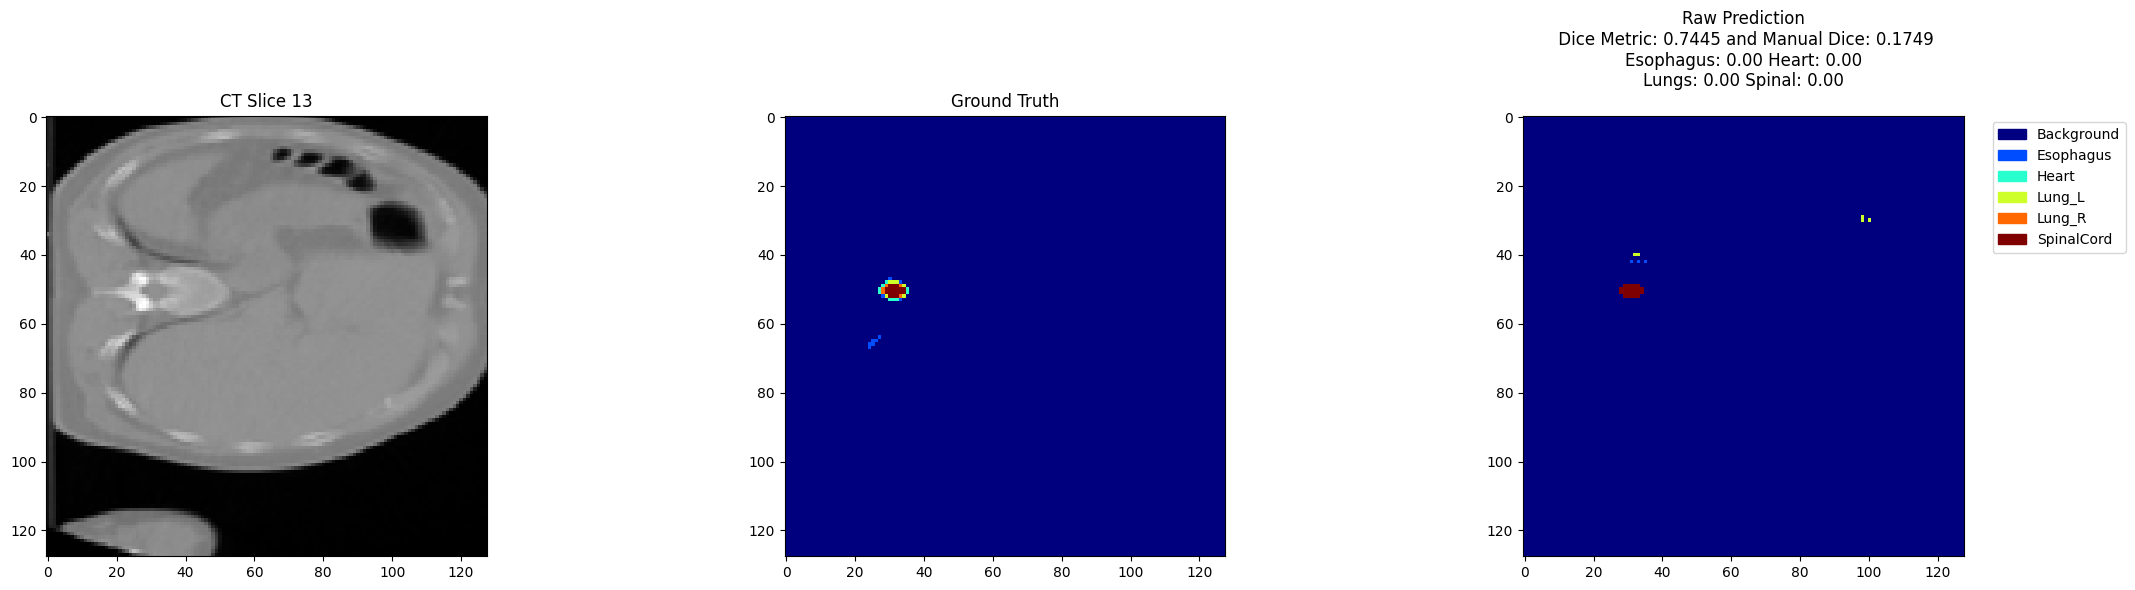

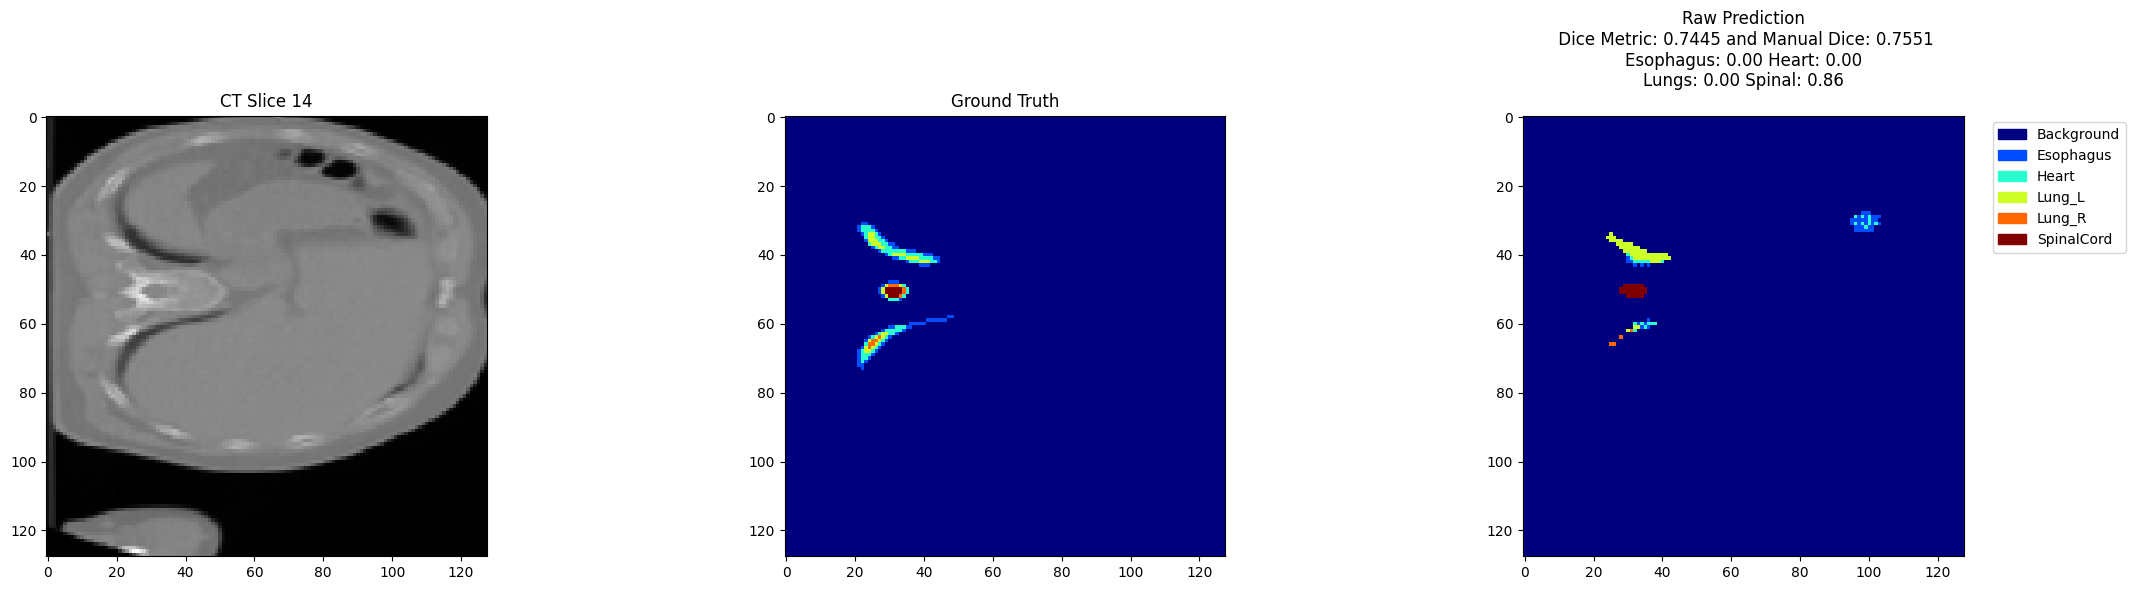

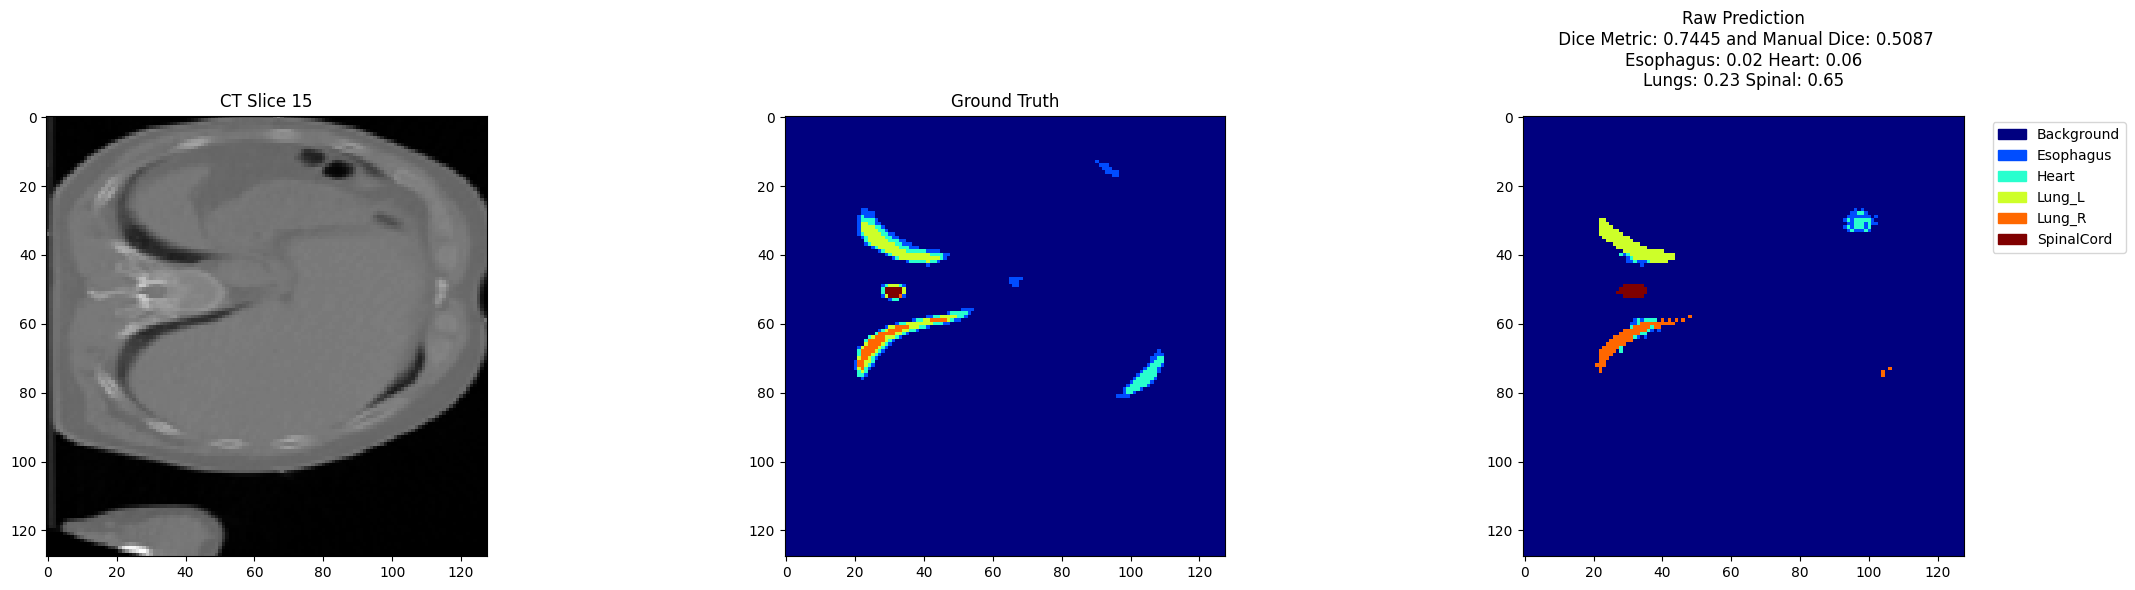

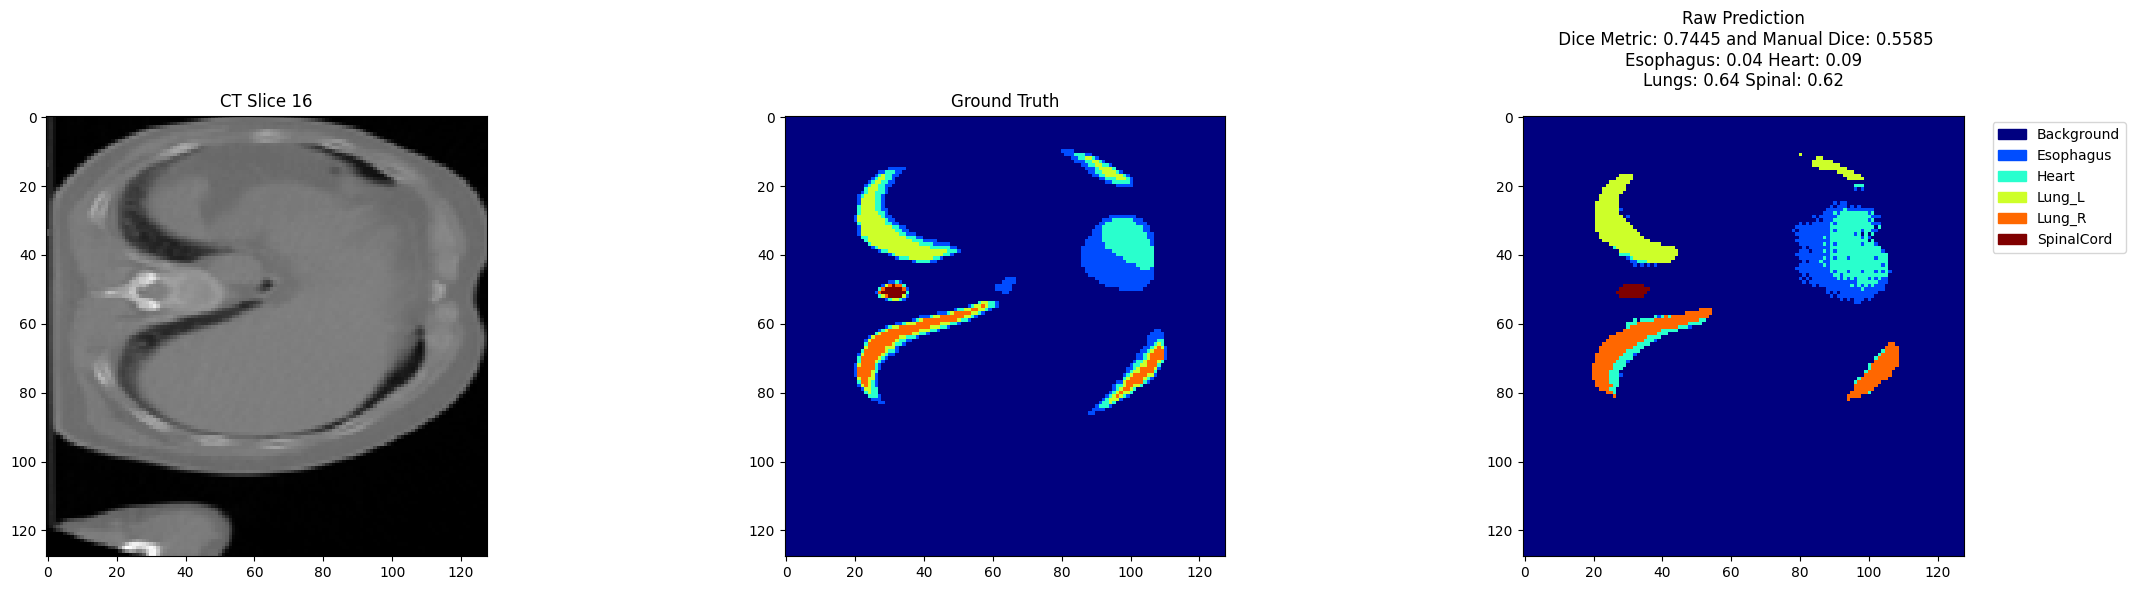

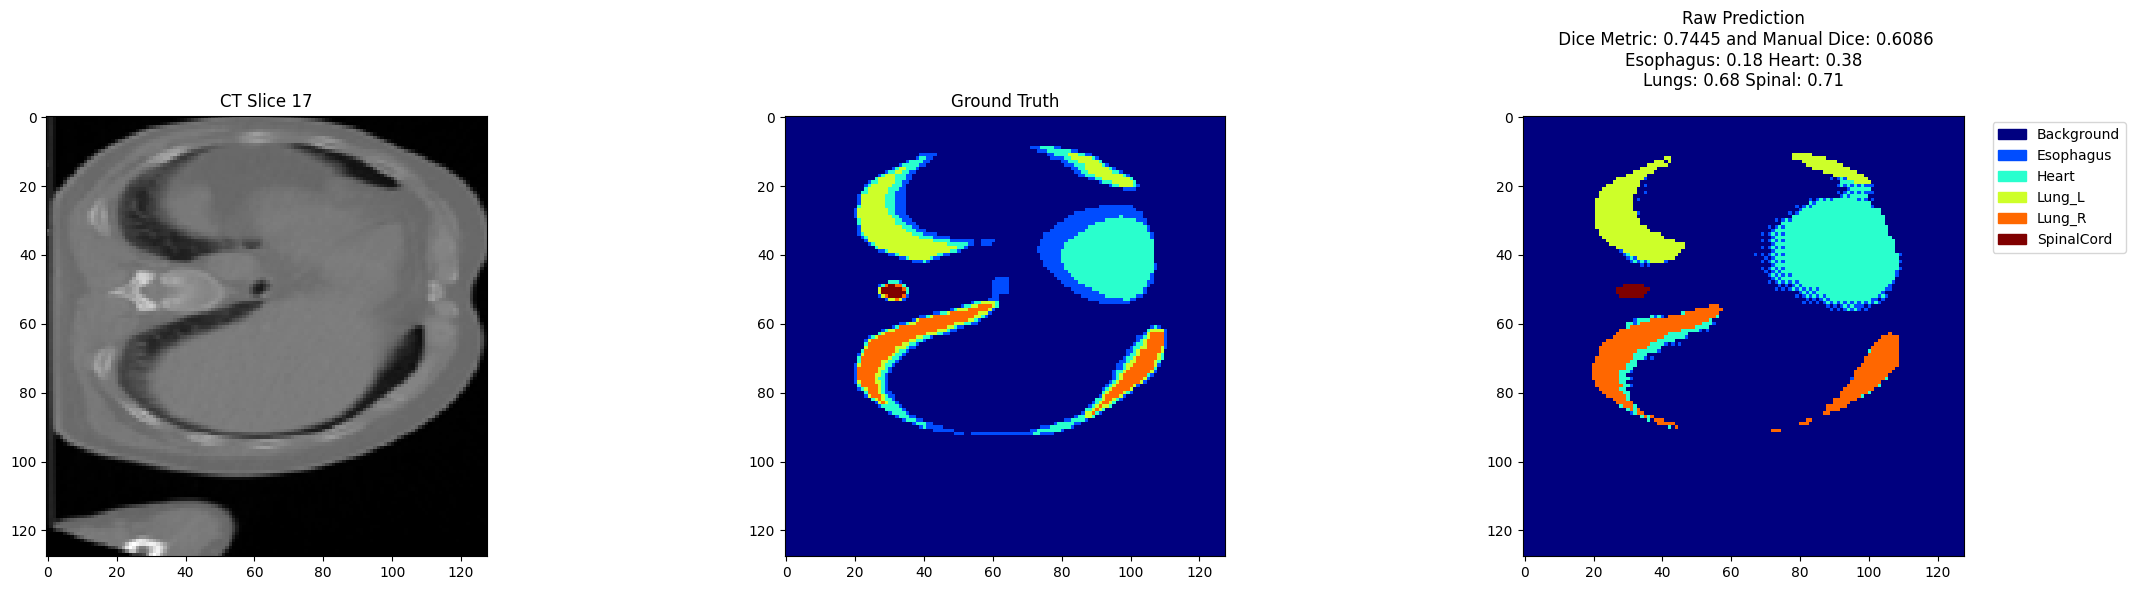

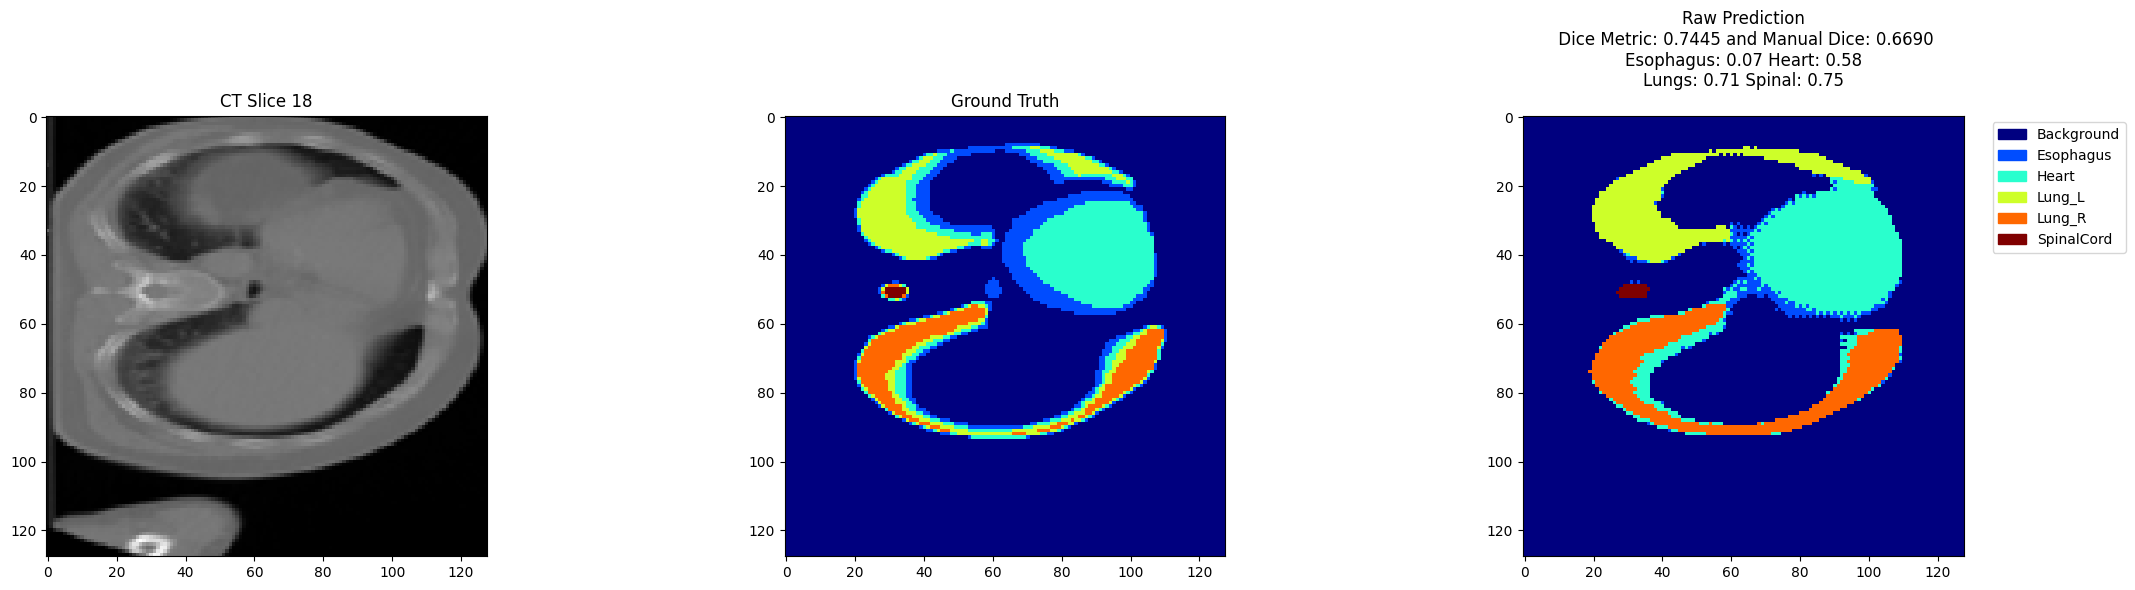

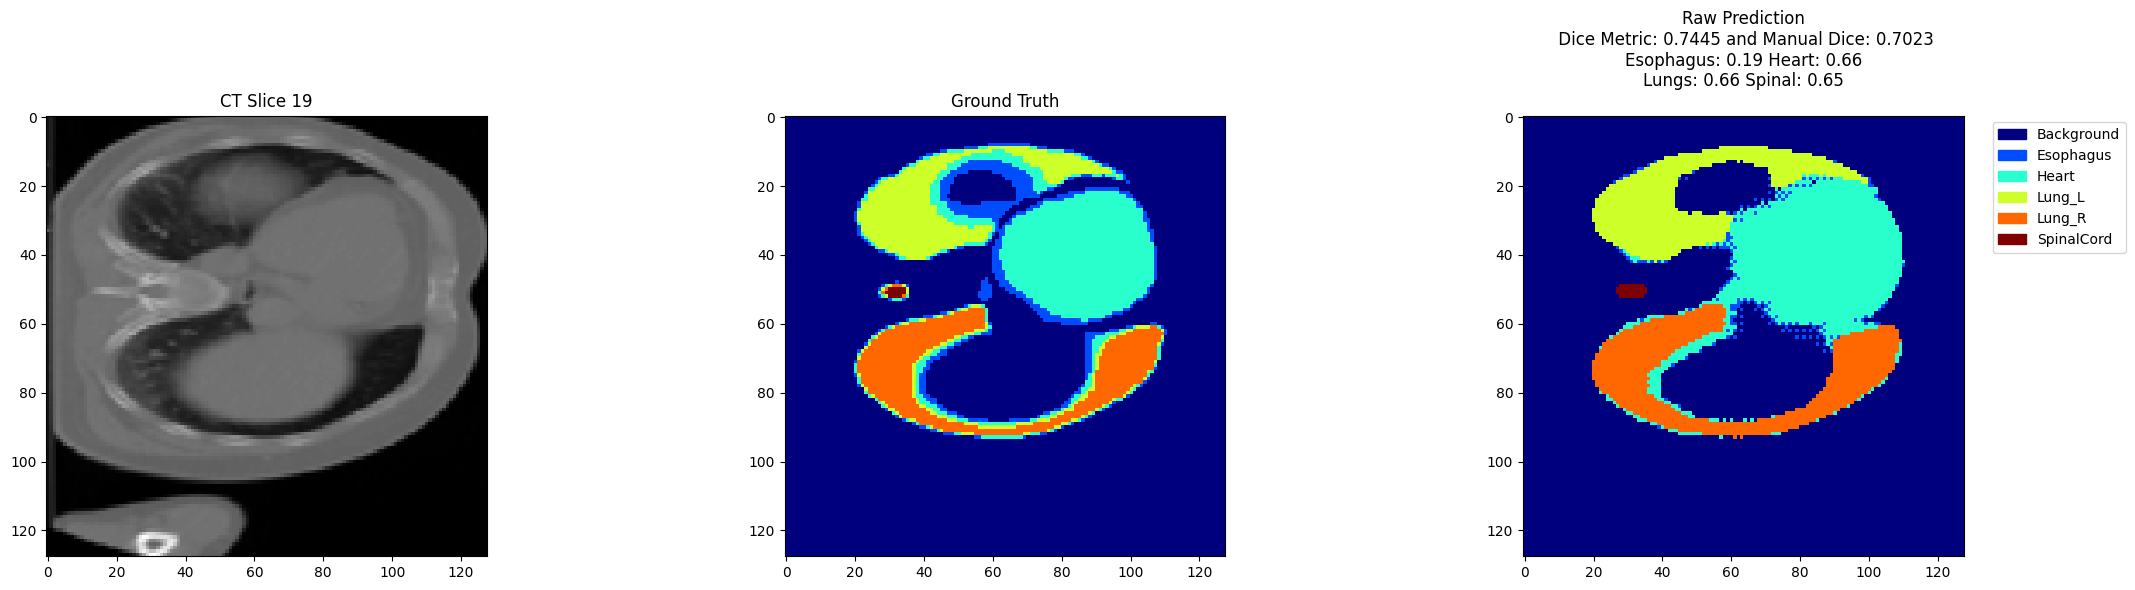

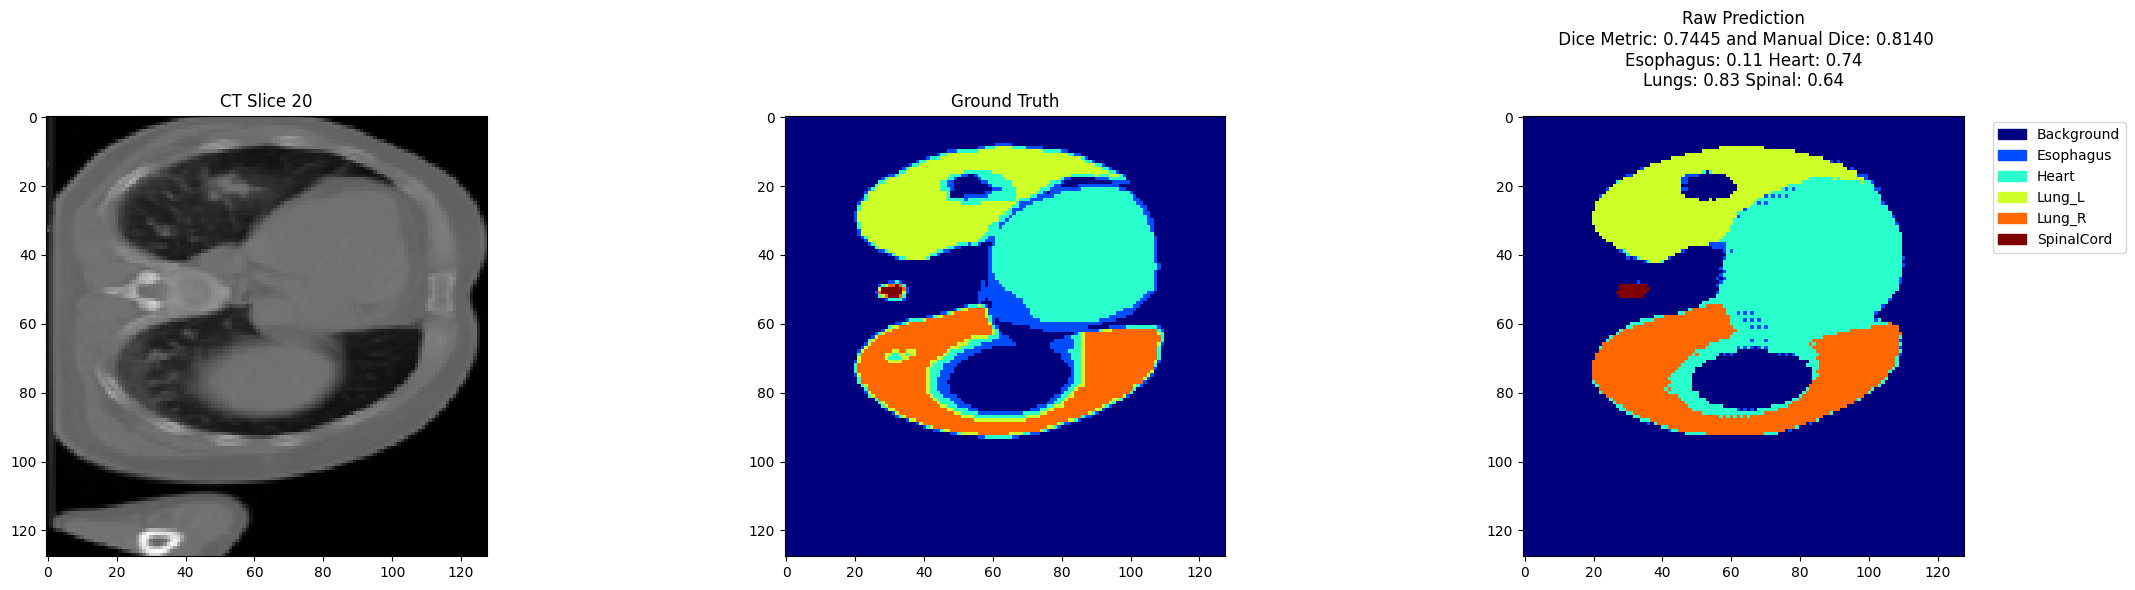

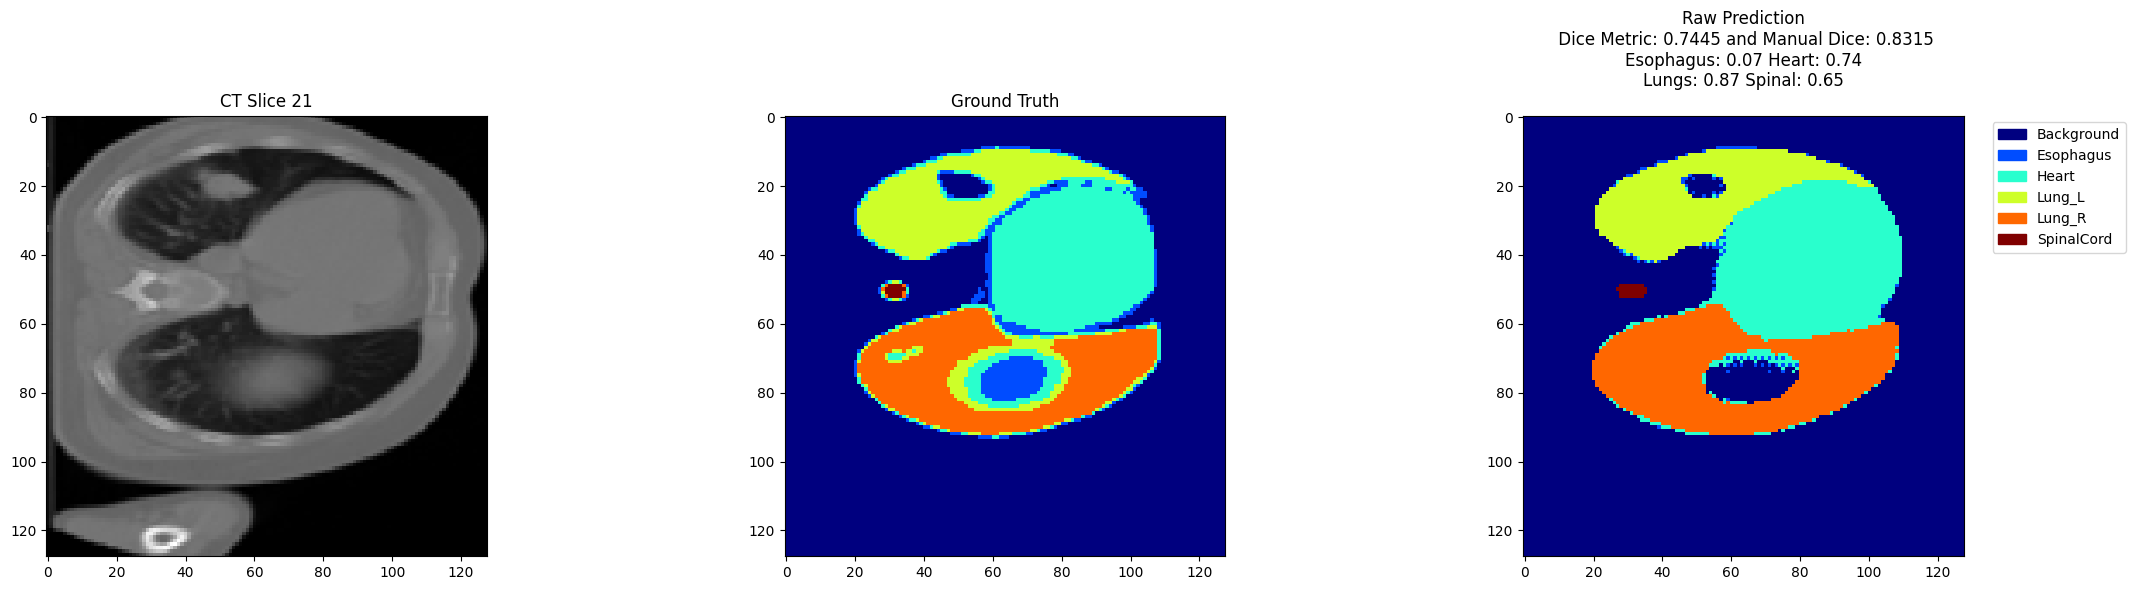

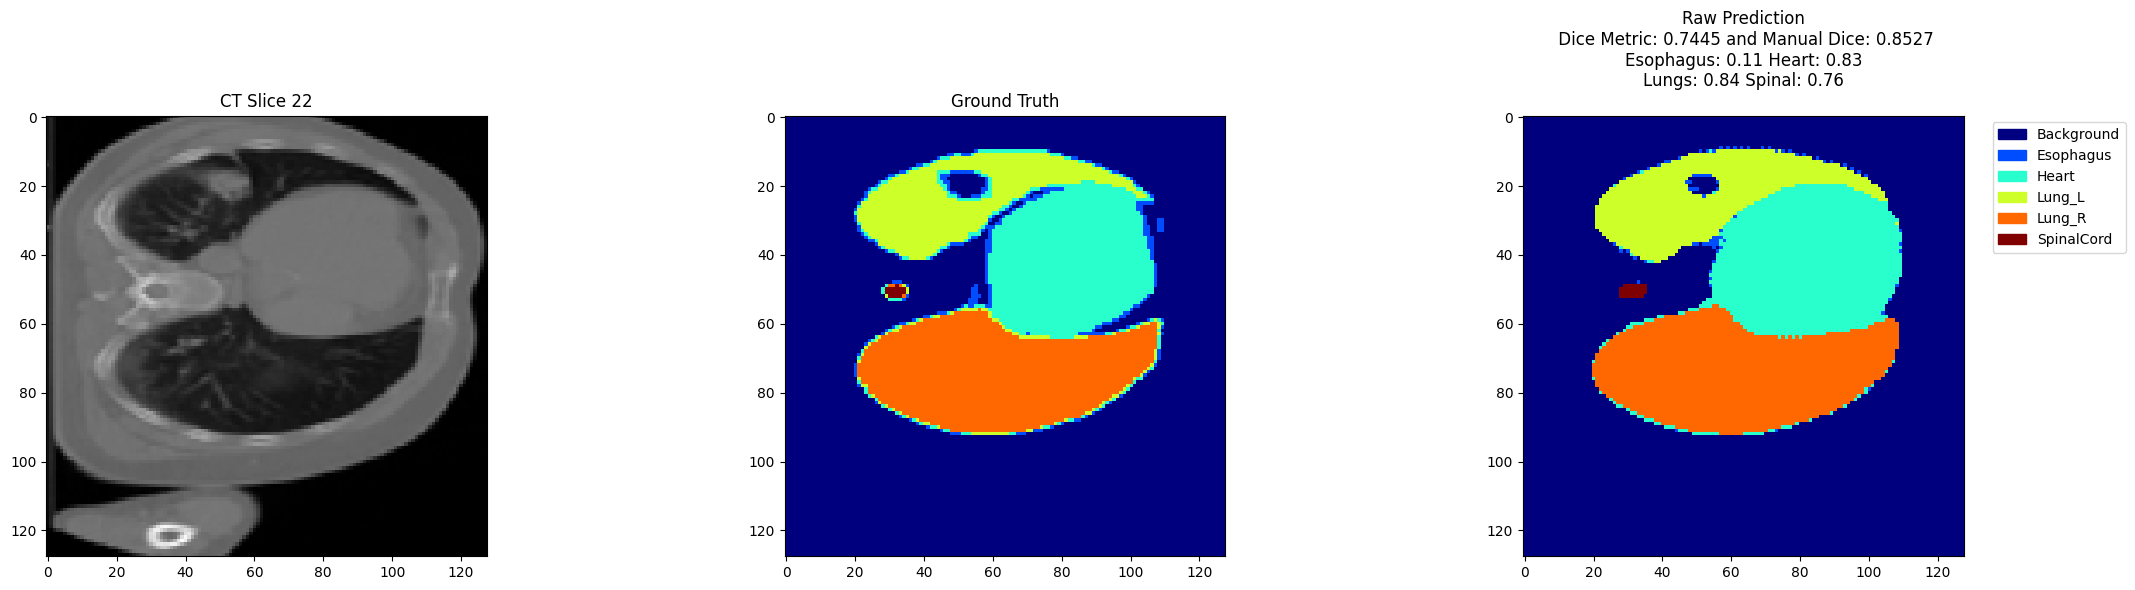

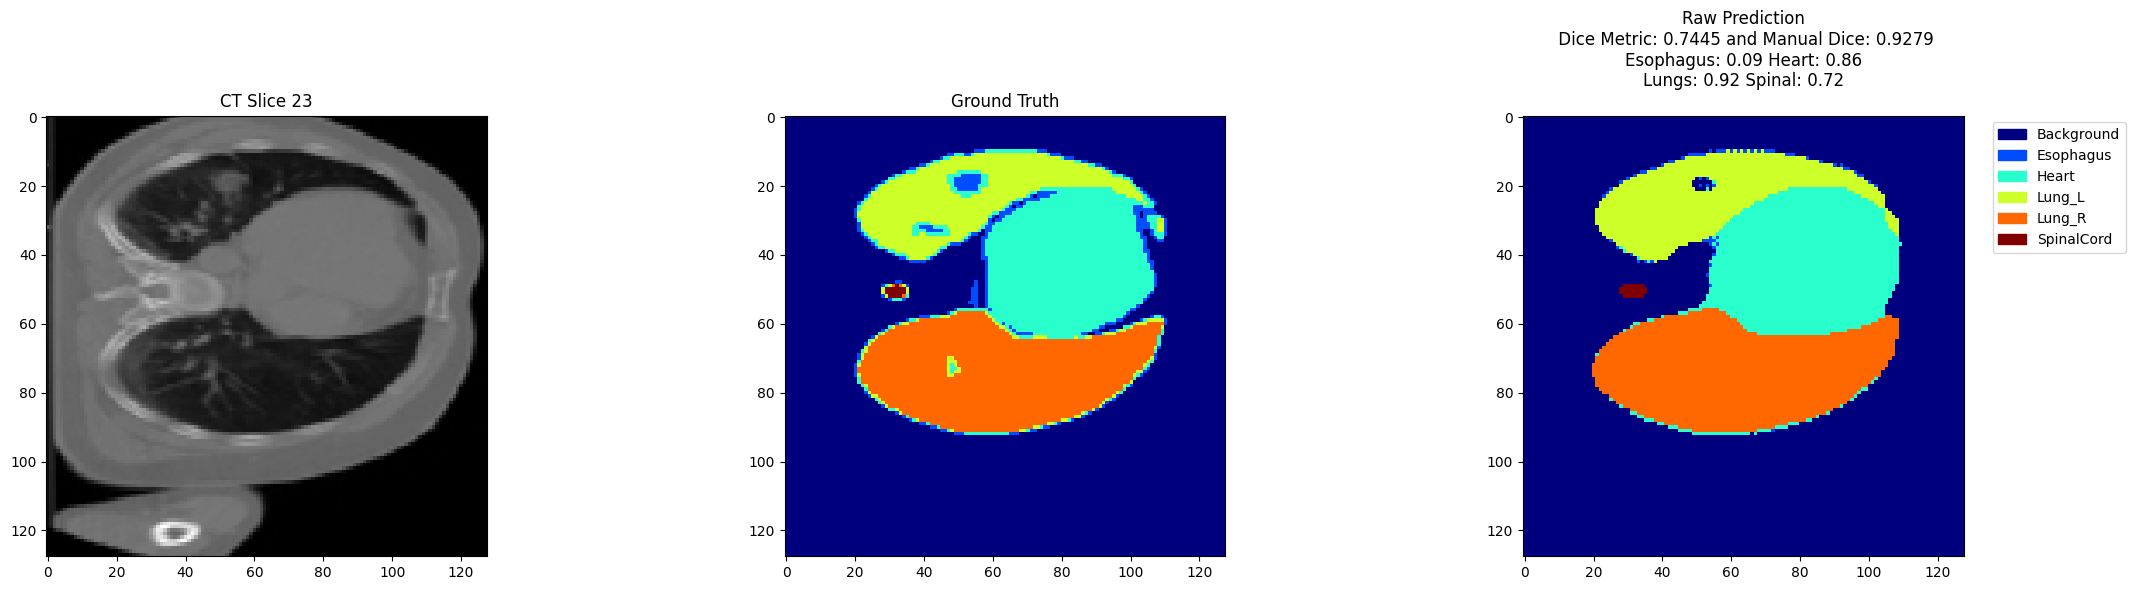

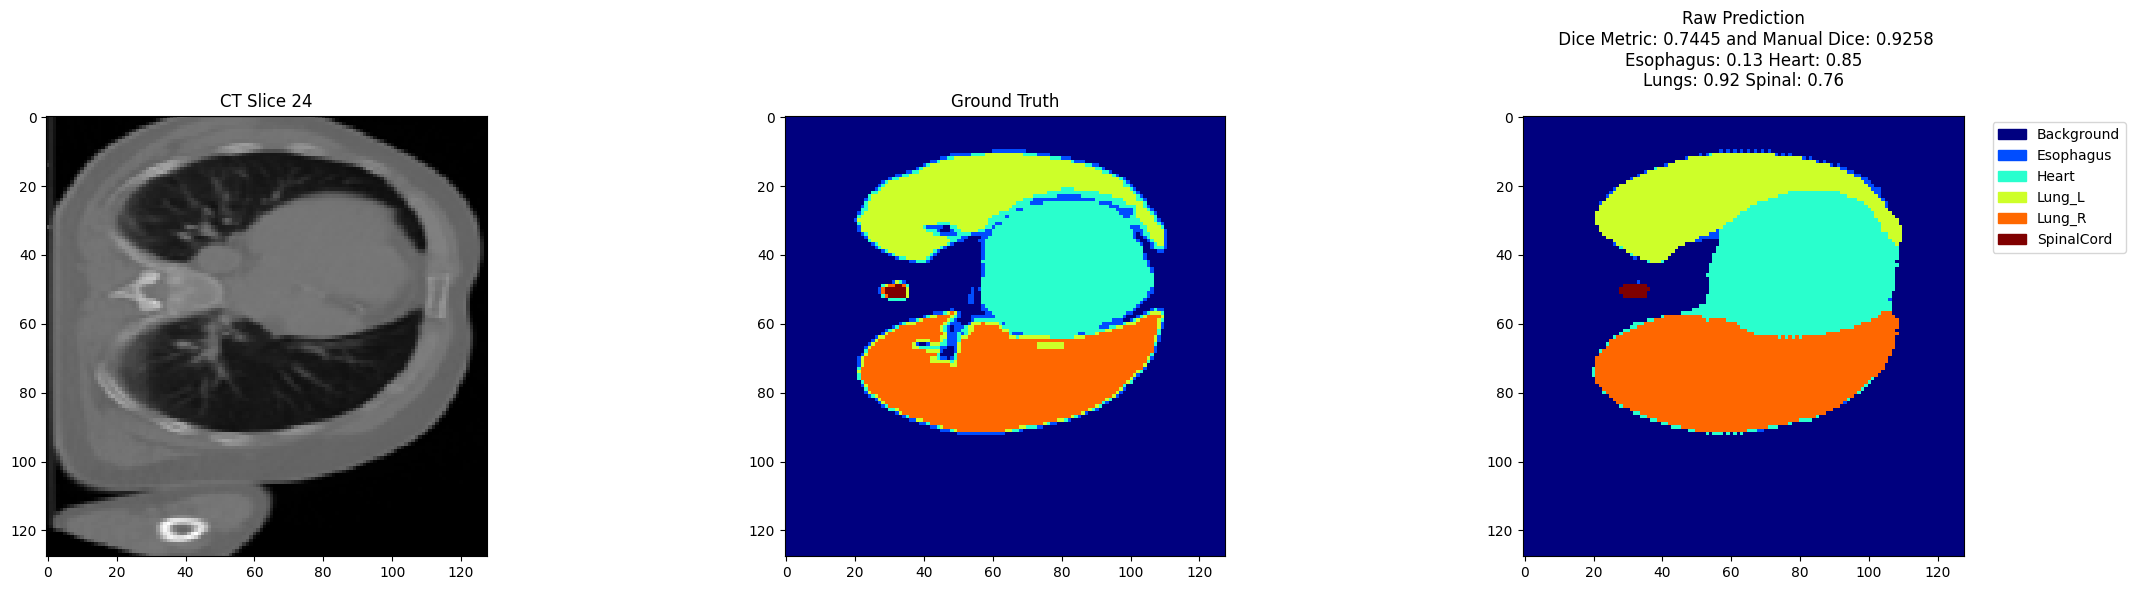

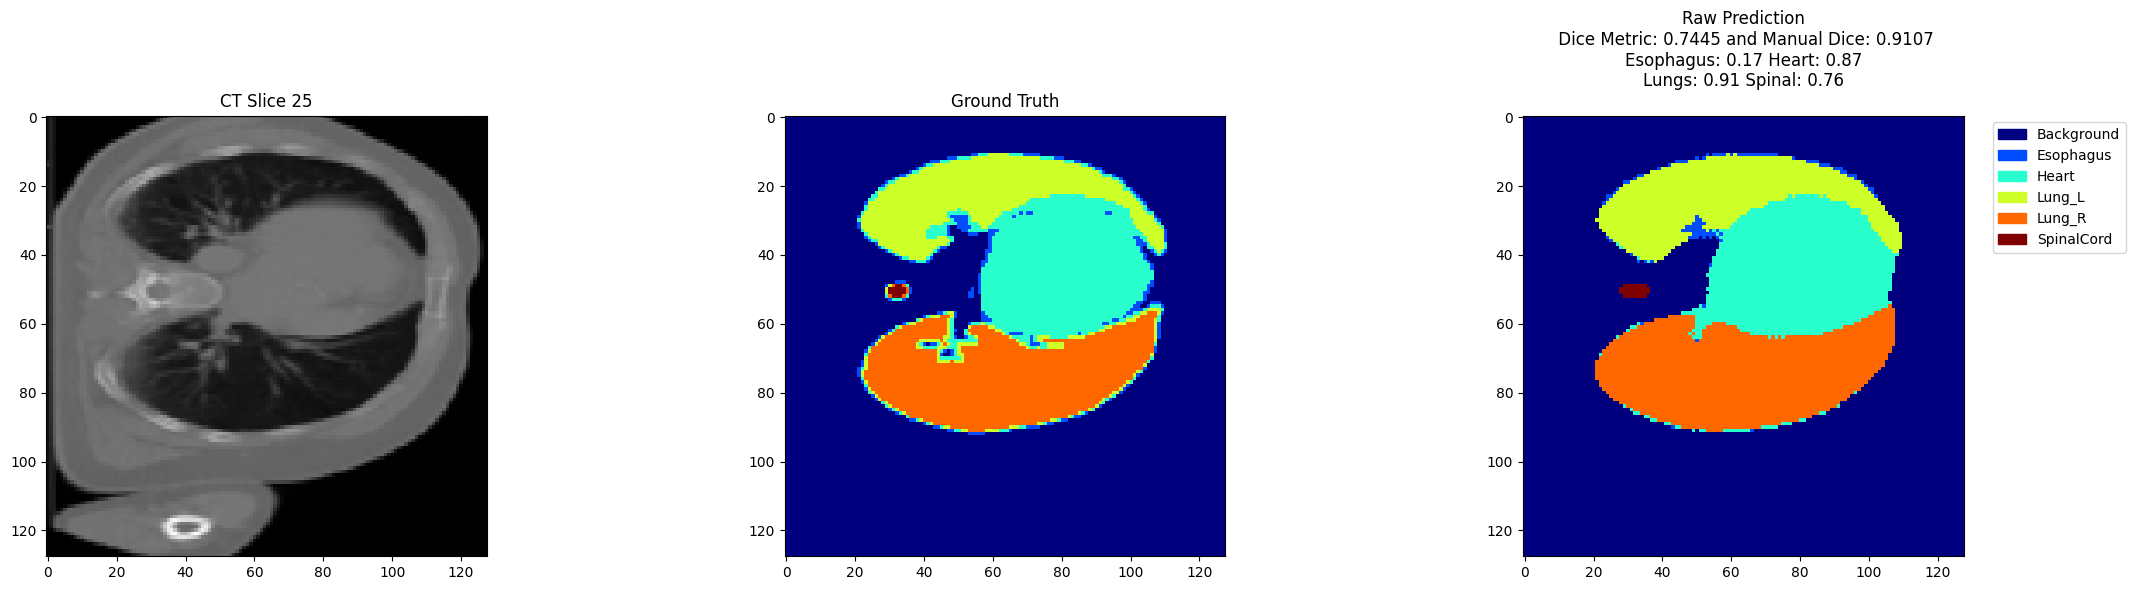

KeyboardInterrupt: 

In [ ]:
# Visualize multiple slices
visualize_patient_slices_with_metrics(
        test_loader=test_loader,
        model=model,
        device=device,
        patient_idx=0
    )

In [ ]:
def calculate_eval_metrics(test_loader, model, device, patient_idx, batch):
    """
    Visualize results with Dice metrics and proper postprocessing
    Args:
        test_loader: Test dataset loader
        model: Trained model
        device: CUDA device
        patient_idx: Index of patient in test_loader
        batch: data batch composed of 4 patients at a time
    """
    # Define postprocessing transforms (DICTIONARY-based)
    post_transforms = Compose([
        EnsureTyped(keys="pred"),  # Ensure tensor type
        #AsDiscreted(keys="pred", argmax=True),  # Convert logits to class indices
        KeepLargestConnectedComponentd(keys="pred", applied_labels=[1,2,3,4,5], independent=True)
    ])

    # Get data
    model.eval()
    with torch.no_grad():
        volume = batch["vol"][patient_idx].unsqueeze(0).to(device)
        label = batch["seg"][patient_idx].unsqueeze(0).to(device)

        # Get raw prediction (logits)
        raw_pred = model(volume)  # [1, 6, H, W, D]

        # Prepare for postprocessing (keep as logits)
        pred_dict = {"pred": raw_pred.cpu()}  # Maintain logits for proper argmax

        # Apply postprocessing
        # postprocessed_dict = post_transforms(pred_dict)
        # postprocessed = postprocessed_dict["pred"]
        # print('postprocessed shape', postprocessed.shape)

    # Convert to numpy for visualization
    volume_np = volume[0,0].cpu().numpy()  # [H, W, D]
    label_np = torch.argmax(label[0], dim=0).cpu().numpy()  # [H, W, D]
    raw_pred_np = torch.argmax(raw_pred[0], dim=0).cpu().numpy()  # [H, W, D]

    # Initialize arrays to store metrics for patient overall and per organ
    overall_dice_item = []
    esophagus_dice_item = []
    esophagus_hd95_item = []
    esophagus_msd_item = []
    heart_dice_item = []
    heart_hd95_item = []
    heart_msd_item = []
    lungs_dice_item = []
    lungs_hd95_item = []
    lungs_msd_item = []
    spinal_dice_item = []
    spinal_hd95_item = []
    spinal_msd_item = []

    esophagus_id = 1
    heart_id = 2
    lung_L_id = 3
    lung_R_id = 4
    spinal_id = 5

    for slice_idx in range(raw_pred_np.shape[-1]):
      #postprocessed_np = torch.argmax(postprocessed[0], dim=0).cpu().numpy()  # [H, W, D]

      # Verify if this slice is 100% background
      #print("Ground truth class indices:", np.unique(label_np[..., slice_idx]))
      #print("Raw pred class indices:", np.unique(raw_pred_np[..., slice_idx+1]))

      # Get slice information
      raw_pred_slice = raw_pred_np[..., slice_idx]
      label_slice = label_np[..., slice_idx]

      if len(np.unique(label_slice)) > 1 or len(np.unique(raw_pred_slice)) > 1:

        # Calculate Dice
        class_dice = class_wise_dice(raw_pred_slice, label_slice)
        calculated_dice = calculate_dice(raw_pred_slice, label_slice)

        # Calculate HD95
        class_hd95 = hd95_per_organ(raw_pred_slice, label_slice)

        # Calculate MSD
        class_msd = msd_per_organ(raw_pred_slice, label_slice, voxel_spacing=(1.5, 1.5, 3))

        overall_dice_item.append(round(calculated_dice, 3))

        if esophagus_id in np.unique(raw_pred_np[..., slice_idx]):
          esophagus_dice_item.append(round(class_dice[0],3))
          esophagus_hd95_item.append(round(class_hd95[0],3))
          esophagus_msd_item.append(round(class_msd[0],3))

        if heart_id in np.unique(raw_pred_np[..., slice_idx]):
          heart_dice_item.append(round(class_dice[1], 3))
          heart_hd95_item.append(round(class_hd95[1],3))
          heart_msd_item.append(round(class_msd[1],3))

        if lung_L_id in np.unique(raw_pred_np[..., slice_idx]) or lung_R_id in np.unique(raw_pred_np[..., slice_idx]):
          lungs_dice_item.append(round(np.mean(class_dice[2:4]), 3))
          lungs_hd95_item.append(round(np.mean(class_hd95[2:4]),3))
          lungs_msd_item.append(round(np.mean(class_msd[2:4]),3))

        if spinal_id in np.unique(raw_pred_np[..., slice_idx]):
          spinal_dice_item.append(round(class_dice[4], 3))
          spinal_hd95_item.append(round(class_hd95[4],3))
          spinal_msd_item.append(round(class_msd[4],3))

          #print('class_dice_array:', class_dice)
          #print('class_hd95_array:', class_hd95)

    #print('overall_dice_item: ', overall_dice_item)
    #print('esophagus_dice_item: ', esophagus_dice_item)
    #print('heart_dice_item: ', heart_dice_item)
    #print('lungs_dice_item: ', lungs_dice_item)
    #print('spinal_dice_item: ', spinal_dice_item)

    new_patient = {
    'patient_name': [patient],
    'overall_dice': [np.mean(overall_dice_item)],
    'esophagus_dice': [np.mean(esophagus_dice_item)],
    'esophagus_hd95': [np.mean(esophagus_hd95_item)],
    'esophagus_msd': [np.mean(esophagus_msd_item) if len(esophagus_msd_item) > 0 else np.nan],
    'heart_dice': [np.mean(heart_dice_item)],
    'heart_hd95': [np.mean(heart_hd95_item)],
    'heart_msd': [np.mean(heart_msd_item) if len(heart_msd_item) > 0 else np.nan],
    'lungs_dice': [np.mean(lungs_dice_item)],
    'lungs_hd95': [np.mean(lungs_hd95_item)],
    'lungs_msd': [np.mean(lungs_msd_item) if len(lungs_msd_item) > 0 else np.nan],
    'spinal_dice': [np.mean(spinal_dice_item)],
    'spinal_hd95': [np.mean(spinal_hd95_item)],
    'spinal_msd': [np.mean(spinal_msd_item) if len(spinal_msd_item) > 0 else np.nan]
    }

    new_patient = pd.DataFrame(new_patient)

    return new_patient


In [ ]:
results = {
    'patient_name': ['test'],
    'overall_dice': [0],
    'esophagus_dice': [0],
    'esophagus_hd95': [0],
    'esophagus_msd': [0],
    'heart_dice': [0],
    'heart_hd95': [0],
    'heart_msd': [0],
    'lungs_dice': [0],
    'lungs_hd95': [0],
    'lungs_msd': [0],
    'spinal_dice': [0],
    'spinal_hd95': [0],
    'spinal_msd': [0]
}

results = pd.DataFrame(results)

#for patient in range(len(test_ds.data)):

for batch in test_loader:
  for patient in range(4):
    new_patient = calculate_eval_metrics(test_loader, model, device, patient, batch)
    results = pd.concat([results, new_patient], ignore_index = True)

results


,patient_name,overall_dice,esophagus_dice,esophagus_hd95,esophagus_msd,heart_dice,heart_hd95,heart_msd,lungs_dice,lungs_hd95,lungs_msd,spinal_dice,spinal_hd95,spinal_msd
0,test,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0.714000,0.206829,21.221943,6.150029,0.380909,22.038576,7.104879,0.823118,28.504000,9.608706,0.549429,12.013143,11.260524
2,1,0.693600,0.192214,14.048821,4.391607,0.322200,15.767960,5.462680,0.798308,19.742308,6.795231,0.541171,5.781971,5.156943
3,2,0.761453,0.109980,31.635880,9.864480,0.443380,21.536340,6.036460,0.573346,33.905250,23.676538,0.715918,2.441574,1.230262
4,3,0.761942,0.167050,25.707000,7.361350,0.351294,29.160765,9.563647,0.850486,25.462600,9.446486,0.629385,8.174558,6.826192
5,0,0.768053,0.187167,19.090833,5.492714,0.406943,28.696000,8.678486,0.839368,27.686447,10.099816,0.642214,3.117768,1.610893
6,1,0.714270,0.226533,19.318567,5.141700,0.410679,18.815036,6.489857,0.805333,22.729300,8.230800,0.663778,3.430806,2.770861
7,2,0.771846,0.199725,20.616650,6.064925,0.352857,25.973314,8.718800,0.841286,30.553800,11.659714,0.545019,5.748212,4.454500
8,3,0.398094,0.124382,26.978000,12.065941,0.232781,28.191063,14.163812,0.779294,30.237265,14.991147,0.569684,1.775684,1.205316


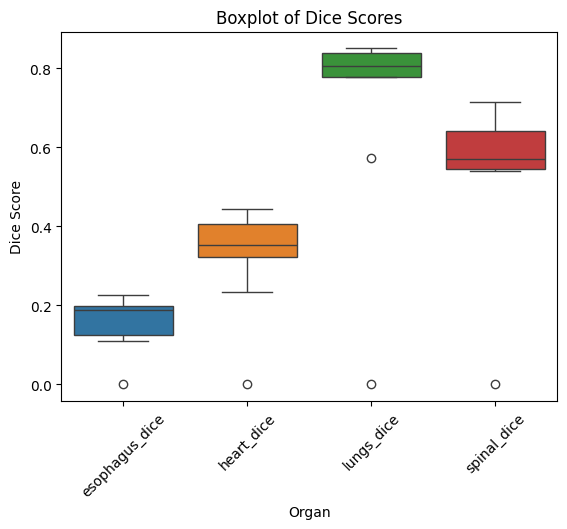

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=results[['esophagus_dice', 'heart_dice', 'lungs_dice', 'spinal_dice']])
plt.title('Boxplot of Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Organ')
plt.xticks(rotation=45)
plt.show()

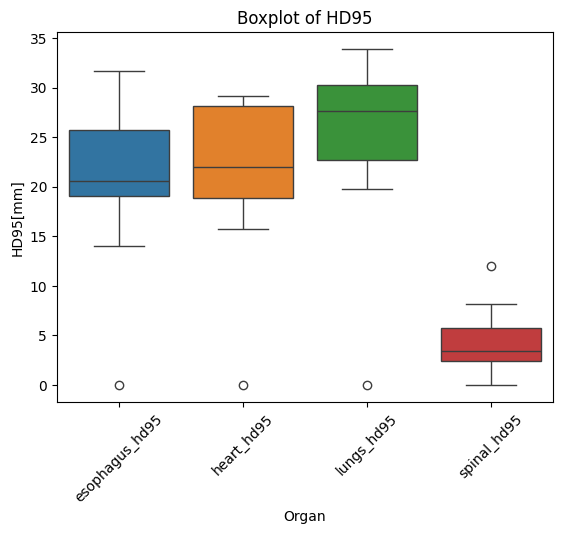

In [ ]:
sns.boxplot(data=results[['esophagus_hd95', 'heart_hd95', 'lungs_hd95', 'spinal_hd95']])
plt.title('Boxplot of HD95')
plt.ylabel('HD95[mm]')
plt.xlabel('Organ')
plt.xticks(rotation=45)
plt.show()

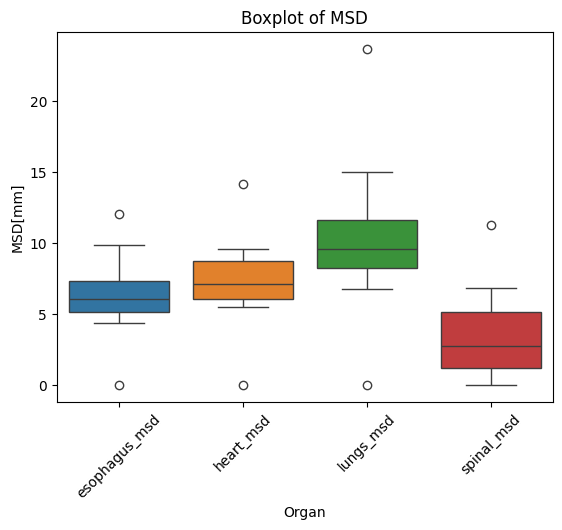

In [ ]:
sns.boxplot(data=results[['esophagus_msd', 'heart_msd', 'lungs_msd', 'spinal_msd']])
plt.title('Boxplot of MSD')
plt.ylabel('MSD[mm]')
plt.xlabel('Organ')
plt.xticks(rotation=45)
plt.show()